In [18]:
%matplotlib inline
import os
import sys
import pathlib
sys.path.append(os.path.join(str(pathlib.Path().resolve()), '../lib'))
from fancy_plot import *
import numpy as np
import pickle
from scipy.optimize import curve_fit
import glob
import pandas as pd
import datetime
import pytz
from tzwhere import tzwhere
import pickle
import copy
from dateutil import parser
from datetime import datetime
from scipy.stats import gaussian_kde

def to_flxnet_date(time):
    return np.int64('{}{:02d}{:02d}{:02d}{:02d}'.format(time.year, time.month, time.day,
                                                        time.hour,time.minute)) 

def make_prediction_for_site(data, target_key,
                             res_gpp, res_nee):
    spred, targets, tmps_return = None, None, None
    inputs = data['inputs']
    targets = copy.deepcopy(data['flxnet'][target_key].values)
    tmps_return =  [parser.parse(str(i)) for i in data['timestamps']]
    if len(inputs) == 0:
        print('Nothing to plot. continue')
        return None, None, None
    if 'NEE' in target_key:
        spred = -(res_gpp[0][0] * inputs[:,1] * inputs[:,4]  * inputs[:,3]) * inputs[:,0] * inputs[:,2] / (1 + inputs[:,2]/res_gpp[0][1]) + res_nee[0][0] * (inputs[:,5])  + res_nee[0][1]
    else:
        spred = (res_gpp[0][0] * inputs[:,1] * inputs[:,4]  * inputs[:,3]) * inputs[:,0] * inputs[:,2] / (1 + inputs[:,2]/res_gpp[0][1])
        targets[targets<0] = 0
    return spred, targets, tmps_return


def FFP(zm=None, umean=None, h=None, ustar=None):
    """
    Derive a flux footprint estimate based on the simple parameterisation FFP
    See Kljun, N., P. Calanca, M.W. Rotach, H.P. Schmid, 2015: 
    The simple two-dimensional parameterisation for Flux Footprint Predictions FFP.
    Geosci. Model Dev. 8, 3695-3713, doi:10.5194/gmd-8-3695-2015, for details.
    contact: n.kljun@swansea.ac.uk

    FFP Input
    zm		= Measurement height above displacement height (i.e. z-d), i.e. measurement height above trees [m] n 
    umean	= Mean wind speed at zm [m/s]; 
    h		= Boundary layer height [m]
    ustar   = friction velocity [ms-1]

    FFP output
    x_ci_max  = x location of footprint peak (distance from measurement) [m]
    """
    
    import numpy as np
    import sys

    nx = 800
    xstar_end=30
    
    #Model parameters
    b = -1.9914
    c = 1.4622
    d = 0.1359
    #von Karman
    k = 0.4
    xstarmax = -c / b + d
    x_ci_max = xstarmax * zm / (1. - (zm / h)) * (umean / ustar * k)
    return  x_ci_max

site_info = pd.read_csv('/home/b/b309233/software/VPRM_preprocessor/site_infos.txt',
                         delimiter=' ')

In [2]:
# with open('/work/bd1231/tglauch/VPRM_output_modis_new_sites_new/h18v3_2012.pickle', 'rb') as ifile:
#     in1 = pickle.load(ifile)
# in1 = [i[0] for i in in1['DE-Geb']['input_data']]

In [3]:
# with open('/work/bd1231/tglauch/VPRM_output_modis_new_smearing_lowess/h18v3_2012.pickle', 'rb') as ifile:
#     in2 = pickle.load(ifile)

In [4]:
# in2 = [i[0] for i in in2['DE-Geb']['input_data']]
# fig, ax = newfig(0.9)
# ax.plot(range(len(in1)), in1)
# ax.plot(range(len(in2)), in2)
# fig.show()

In [5]:
site_dict = {'grassland': [ 'CH-Cha', 'CH-Fru', 'DE-Gri', 'DE-RuR', 'IT-MBo', 'IT-Tor'], # 'CZ-BK2'  'AT-Neu'
             'mixed_forests': ['BE-Bra', 'BE-Vie', 'CH-Lae'],
             'cropland': [ 'CH-Oe2', 'DE-Geb', 'DE-Kli', 'FR-Gri', 'IT-CA2'], # 'IT-BCi' 'DE-RuS' # 'BE-Lon' problematic site, only works for very small footprints
             'evergeen': ['CZ-BK1', 'DE-Obe', 'DE-Tha', 'FI-Hyy', 'FI-Let', 
                          'IT-Lav', 'IT-Ren',  'NL-Loo'],# 'IT-SRo' 'FI-Sod', 'RU-Fyo' 'DE-Lkb' 'CH-Dav'
           #  'wetland': ['CZ-wet', 'DE-Akm', 'DE-SfN', 'DE-Spw', 'FR-Pue', 'IT-Cp2'],
             'deciduous': ['DE-Hai', 'DE-Lnf', 'DK-Sor', 'FR-Fon', 'IT-CA1', 'IT-Col', 'IT-Ro2'], # 'IT-CA3'
             'shrubland': ['ES-LJu', 'IT-Noe']} # 'ES-Amo'

veg_type_id = {'grassland': 7, 'mixed_forests': 3 , 'cropland':6, 
               'evergeen': 1, 'deciduous': 2, 'shrubland':4} # 'wetland': 8


In [6]:
# for key in site_dict.keys():
#     for key2 in site_dict[key]:
#         try:
#             mh = float(site_info.loc[site_info['Site_name']==key2]['measurement_height'].values)
#             ch = float(site_info.loc[site_info['Site_name']==key2]['canopy_height'].values)
#             print(key2, mh-ch)
#         except:
#             print(key2)

In [7]:
input_data= {'modis': '/work/bd1231/tglauch/VPRM_output_modis/*_{}.pickle',
             'viirs' : '/work/bd1231/tglauch//VPRM_output_viirs/*_{}.pickle'} 

In [8]:
# test = '/work/bd1231/tglauch/data/FLX_FI-Hyy_FLUXNET2015_FULLSET_1996-2014_1-4/FLX_FI-Hyy_FLUXNET2015_FULLSET_HH_1996-2014_1-4.csv'
# idata = pd.read_csv(test)

In [9]:
# idata

In [10]:
# idata.loc[idata['TIMESTAMP_START']==201205031200]['GPP_DT_VUT_REF']

In [11]:
# plt.hist(FFP(zm=10, umean=idata['WS'], h=1000, ustar=idata['USTAR']), bins=np.linspace(0,500, 200))

In [12]:
# for i in sorted(idata.keys()):
#     print(i)

In [13]:
# ls /work/bd1231/tglauch/data/FLX_CH-Dav_FLUXNET2015_FULLSET_1997-2014_1-4/

In [14]:
# for i in idata['VARIABLE']:
#     if 'FETCH' in i:
#         print(i)

In [15]:
# for i in idata.keys():
#     print(i)

In [16]:
# full_dict['modis']['grassland']['DE-Gri']['flxnet'].keys()

In [17]:
full_dict = dict()
for year in [2012, 2013, 2014]:
    print(year)
    for key in input_data.keys():
        print(key)
        data_dict = dict()
        for cvt, veg_type in enumerate(site_dict.keys()):
            data_dict[veg_type] = dict()
            for f in glob.glob(input_data[key].format(year)):
                with open(f, 'rb') as ifile:
                    idata = pickle.load(ifile)
                for c_site, site in enumerate(site_dict[veg_type]):
                    add_dict = dict()
                    if site not in idata.keys():
                        continue
                    print(site)
                    ipt = np.array(idata[site]['input_data'])
                    flxnet = idata[site]['fluxnet_data']
                    idata[site]['input_data_timestamps'] = np.array([to_flxnet_date(i) for i in idata[site]['input_data_timestamps']])
                    mask1 = [True if i in idata[site]['input_data_timestamps'] else False
                             for i in flxnet['TIMESTAMP_END'].values]
                    mask2 = [True if i in flxnet['TIMESTAMP_END'].values else False
                             for i in idata[site]['input_data_timestamps']]
                    add_dict['flxnet'] = flxnet[mask1]
                    #add_dict['targets_nee'] = np.array(flxnet['NEE_VUT_REF'][mask1].values)
                    add_dict['inputs'] = np.array(ipt[mask2])
                    #add_dict['targets_gpp'] = np.array(flxnet['GPP_DT_VUT_REF'][mask1].values)
                    add_dict['timestamps'] = np.array(idata[site]['input_data_timestamps'][mask2])
                    data_dict[veg_type][site] = add_dict
        if key not in full_dict.keys():
            full_dict[key] = data_dict
        else:
            for veg_type in full_dict[key].keys():
                for site in full_dict[key][veg_type].keys():
                    for arr in full_dict[key][veg_type][site].keys():
                        if site in data_dict[veg_type].keys():
                            to_concat = [full_dict[key][veg_type][site][arr],
                                         data_dict[veg_type][site][arr]]
                            if arr == 'flxnet':
                                full_dict[key][veg_type][site][arr] = pd.concat(to_concat)
                            else:
                                full_dict[key][veg_type][site][arr] = np.concatenate(to_concat)

2012
modis
CH-Cha
CH-Fru
IT-MBo
IT-Tor
DE-Gri
DE-RuR
CH-Lae
BE-Bra
BE-Vie
CH-Oe2
FR-Gri
IT-CA2
DE-Geb
DE-Kli
FI-Hyy
FI-Let
IT-Lav
IT-Ren
DE-Obe
DE-Tha
NL-Loo
CZ-BK1
FR-Fon
IT-CA1
IT-Ro2
DE-Hai
DE-Lnf
DK-Sor
IT-Col
IT-Noe
ES-LJu
viirs
CH-Cha
CH-Fru
IT-MBo
IT-Tor
DE-Gri
DE-RuR
CH-Lae
BE-Bra
BE-Vie
CH-Oe2
FR-Gri
IT-CA2
DE-Geb
DE-Kli
FI-Hyy
FI-Let
IT-Lav
IT-Ren
DE-Obe
DE-Tha
NL-Loo
CZ-BK1
FR-Fon
IT-CA1
IT-Ro2
DE-Hai
DE-Lnf
DK-Sor
IT-Col
IT-Noe
ES-LJu
2013
modis
DE-Gri
DE-RuR
CH-Cha
CH-Fru
IT-MBo
IT-Tor
BE-Bra
BE-Vie
CH-Lae
DE-Geb
DE-Kli
CH-Oe2
FR-Gri
IT-CA2
CZ-BK1
FI-Hyy
DE-Obe
DE-Tha
NL-Loo
IT-Lav
IT-Ren
IT-Col
DK-Sor
FR-Fon
IT-CA1
IT-Noe
viirs
DE-Gri
DE-RuR
CH-Cha
CH-Fru
IT-MBo
IT-Tor
BE-Bra
BE-Vie
CH-Lae
DE-Geb
DE-Kli
CH-Oe2
FR-Gri
IT-CA2
CZ-BK1
FI-Hyy
DE-Obe
DE-Tha
NL-Loo
IT-Lav
IT-Ren
IT-Col
DK-Sor
FR-Fon
IT-CA1
ES-LJu
IT-Noe
2014
modis
CH-Cha
CH-Fru
IT-Tor
DE-Gri
DE-RuR
CH-Lae
BE-Bra
BE-Vie
CH-Oe2
FR-Gri
IT-CA2
DE-Geb
DE-Kli
FI-Hyy
IT-Lav
CZ-BK1
DE-Obe
DE-Tha
NL-Loo
FR-Fon
IT-CA1
IT-

-----
grassland
95982
MSE GPP: 12.598567644144394
MSE NEE: 16.371688581716153


/tmp/ipykernel_1108603/2438770944.py:194: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('/work/bd1231/tglauch/plots/{}_{}.jpg'.format(key, site), dpi=300,
/tmp/ipykernel_1108603/2438770944.py:194: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('/work/bd1231/tglauch/plots/{}_{}.jpg'.format(key, site), dpi=300,
/tmp/ipykernel_1108603/2438770944.py:194: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('/work/bd1231/tglauch/plots/{}_{}.jpg'.format(key, site), dpi=300,
/tmp/ipykernel_1108603/2438770944.py:194: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('/work/bd1231/tglauch/plots/{}_{}.jpg'.format(key, site), dpi=300,
/tmp/ipykernel_1108603/2438770944.py:194: UserWarning: T

mixed_forests
67329
MSE GPP: 8.959784018184944
MSE NEE: 19.670824999556658


/tmp/ipykernel_1108603/2438770944.py:194: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('/work/bd1231/tglauch/plots/{}_{}.jpg'.format(key, site), dpi=300,
/tmp/ipykernel_1108603/2438770944.py:194: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('/work/bd1231/tglauch/plots/{}_{}.jpg'.format(key, site), dpi=300,
/tmp/ipykernel_1108603/2438770944.py:194: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('/work/bd1231/tglauch/plots/{}_{}.jpg'.format(key, site), dpi=300,


cropland
101985
MSE GPP: 16.741984890106796
MSE NEE: 16.07261250699092


/tmp/ipykernel_1108603/2438770944.py:194: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('/work/bd1231/tglauch/plots/{}_{}.jpg'.format(key, site), dpi=300,
/tmp/ipykernel_1108603/2438770944.py:194: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('/work/bd1231/tglauch/plots/{}_{}.jpg'.format(key, site), dpi=300,
/tmp/ipykernel_1108603/2438770944.py:194: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('/work/bd1231/tglauch/plots/{}_{}.jpg'.format(key, site), dpi=300,
/tmp/ipykernel_1108603/2438770944.py:194: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('/work/bd1231/tglauch/plots/{}_{}.jpg'.format(key, site), dpi=300,
/tmp/ipykernel_1108603/2438770944.py:194: UserWarning: T

evergeen
62944
MSE GPP: 6.172526736504095
MSE NEE: 10.993899329245446


/tmp/ipykernel_1108603/2438770944.py:194: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('/work/bd1231/tglauch/plots/{}_{}.jpg'.format(key, site), dpi=300,
/tmp/ipykernel_1108603/2438770944.py:194: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('/work/bd1231/tglauch/plots/{}_{}.jpg'.format(key, site), dpi=300,
/tmp/ipykernel_1108603/2438770944.py:194: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('/work/bd1231/tglauch/plots/{}_{}.jpg'.format(key, site), dpi=300,
/tmp/ipykernel_1108603/2438770944.py:194: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('/work/bd1231/tglauch/plots/{}_{}.jpg'.format(key, site), dpi=300,
/tmp/ipykernel_1108603/2438770944.py:194: UserWarning: T

deciduous
47726
MSE GPP: 8.400886950483738
MSE NEE: 11.506290222993377


/tmp/ipykernel_1108603/2438770944.py:194: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('/work/bd1231/tglauch/plots/{}_{}.jpg'.format(key, site), dpi=300,
/tmp/ipykernel_1108603/2438770944.py:194: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('/work/bd1231/tglauch/plots/{}_{}.jpg'.format(key, site), dpi=300,
/tmp/ipykernel_1108603/2438770944.py:194: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('/work/bd1231/tglauch/plots/{}_{}.jpg'.format(key, site), dpi=300,
/tmp/ipykernel_1108603/2438770944.py:194: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('/work/bd1231/tglauch/plots/{}_{}.jpg'.format(key, site), dpi=300,
/tmp/ipykernel_1108603/2438770944.py:194: UserWarning: T

shrubland
16712
MSE GPP: 3.11907427951346
MSE NEE: 2.7213979666700725


/tmp/ipykernel_1108603/2438770944.py:194: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('/work/bd1231/tglauch/plots/{}_{}.jpg'.format(key, site), dpi=300,
/tmp/ipykernel_1108603/2438770944.py:194: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('/work/bd1231/tglauch/plots/{}_{}.jpg'.format(key, site), dpi=300,


-----
grassland
95982
MSE GPP: 12.364047442273938
MSE NEE: 16.51442435443235


/tmp/ipykernel_1108603/2438770944.py:194: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('/work/bd1231/tglauch/plots/{}_{}.jpg'.format(key, site), dpi=300,
/tmp/ipykernel_1108603/2438770944.py:194: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('/work/bd1231/tglauch/plots/{}_{}.jpg'.format(key, site), dpi=300,
/tmp/ipykernel_1108603/2438770944.py:194: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('/work/bd1231/tglauch/plots/{}_{}.jpg'.format(key, site), dpi=300,
/tmp/ipykernel_1108603/2438770944.py:194: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('/work/bd1231/tglauch/plots/{}_{}.jpg'.format(key, site), dpi=300,
/tmp/ipykernel_1108603/2438770944.py:194: UserWarning: T

mixed_forests
67329
MSE GPP: 10.359096466356387
MSE NEE: 20.08048724161291


/tmp/ipykernel_1108603/2438770944.py:194: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('/work/bd1231/tglauch/plots/{}_{}.jpg'.format(key, site), dpi=300,
/tmp/ipykernel_1108603/2438770944.py:194: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('/work/bd1231/tglauch/plots/{}_{}.jpg'.format(key, site), dpi=300,
/tmp/ipykernel_1108603/2438770944.py:194: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('/work/bd1231/tglauch/plots/{}_{}.jpg'.format(key, site), dpi=300,


cropland
101985
MSE GPP: 15.159484415696031
MSE NEE: 15.111082864863999


/tmp/ipykernel_1108603/2438770944.py:194: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('/work/bd1231/tglauch/plots/{}_{}.jpg'.format(key, site), dpi=300,
/tmp/ipykernel_1108603/2438770944.py:194: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('/work/bd1231/tglauch/plots/{}_{}.jpg'.format(key, site), dpi=300,
/tmp/ipykernel_1108603/2438770944.py:194: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('/work/bd1231/tglauch/plots/{}_{}.jpg'.format(key, site), dpi=300,
/tmp/ipykernel_1108603/2438770944.py:194: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('/work/bd1231/tglauch/plots/{}_{}.jpg'.format(key, site), dpi=300,
/tmp/ipykernel_1108603/2438770944.py:194: UserWarning: T

evergeen
62944
MSE GPP: 6.701405873192725
MSE NEE: 11.31079649029141


/tmp/ipykernel_1108603/2438770944.py:194: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('/work/bd1231/tglauch/plots/{}_{}.jpg'.format(key, site), dpi=300,
/tmp/ipykernel_1108603/2438770944.py:194: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('/work/bd1231/tglauch/plots/{}_{}.jpg'.format(key, site), dpi=300,
/tmp/ipykernel_1108603/2438770944.py:194: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('/work/bd1231/tglauch/plots/{}_{}.jpg'.format(key, site), dpi=300,
/tmp/ipykernel_1108603/2438770944.py:194: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('/work/bd1231/tglauch/plots/{}_{}.jpg'.format(key, site), dpi=300,
/tmp/ipykernel_1108603/2438770944.py:194: UserWarning: T

deciduous
47726
MSE GPP: 8.35257137150232
MSE NEE: 11.216237204314826


/tmp/ipykernel_1108603/2438770944.py:194: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('/work/bd1231/tglauch/plots/{}_{}.jpg'.format(key, site), dpi=300,
/tmp/ipykernel_1108603/2438770944.py:194: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('/work/bd1231/tglauch/plots/{}_{}.jpg'.format(key, site), dpi=300,
/tmp/ipykernel_1108603/2438770944.py:194: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('/work/bd1231/tglauch/plots/{}_{}.jpg'.format(key, site), dpi=300,
/tmp/ipykernel_1108603/2438770944.py:194: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('/work/bd1231/tglauch/plots/{}_{}.jpg'.format(key, site), dpi=300,
/tmp/ipykernel_1108603/2438770944.py:194: UserWarning: T

shrubland
33376
MSE GPP: 2.2429779269299592
MSE NEE: 2.625843336035561


/tmp/ipykernel_1108603/2438770944.py:194: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('/work/bd1231/tglauch/plots/{}_{}.jpg'.format(key, site), dpi=300,
/tmp/ipykernel_1108603/2438770944.py:194: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('/work/bd1231/tglauch/plots/{}_{}.jpg'.format(key, site), dpi=300,
/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


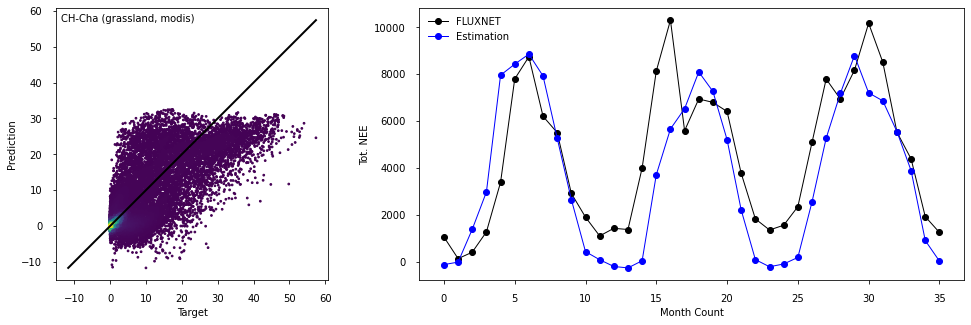

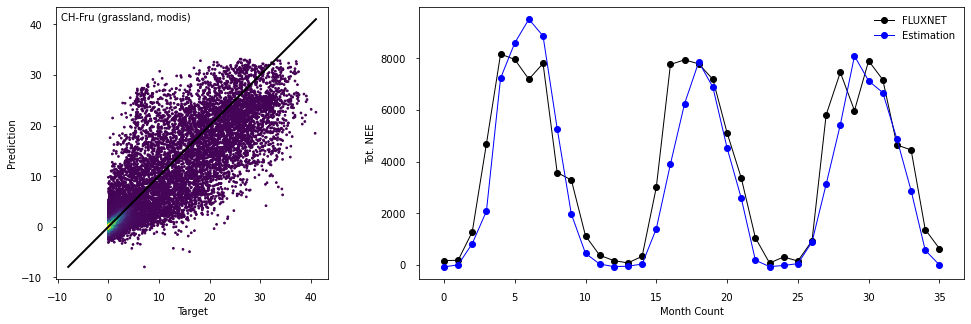

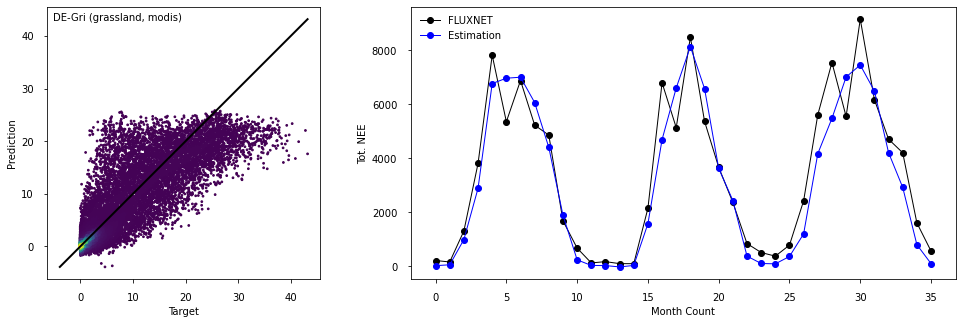

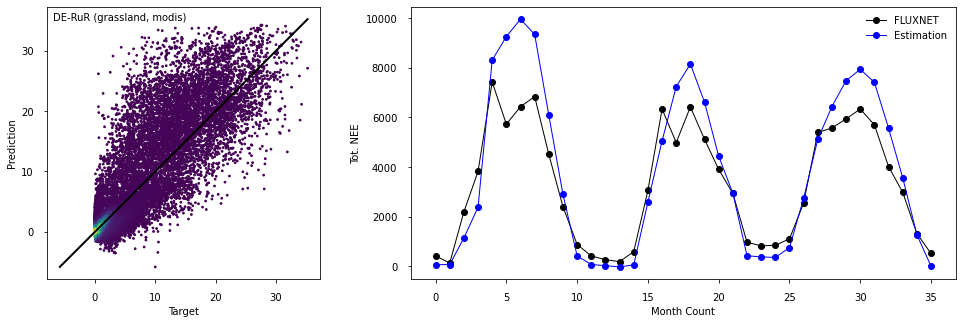

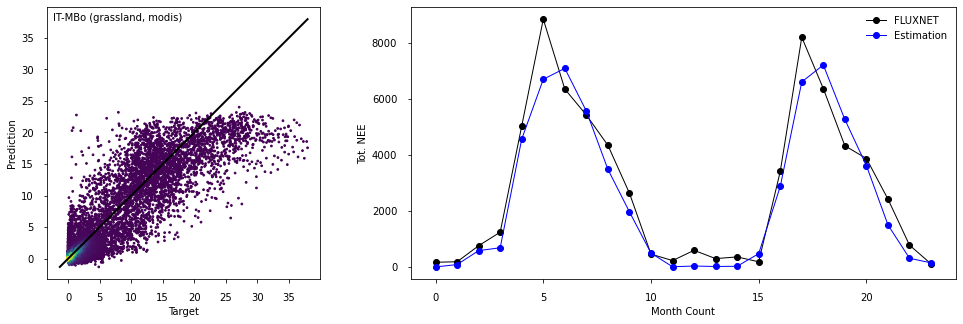

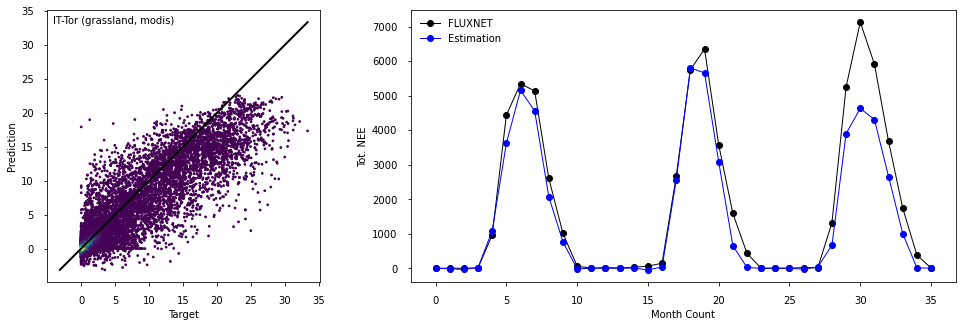

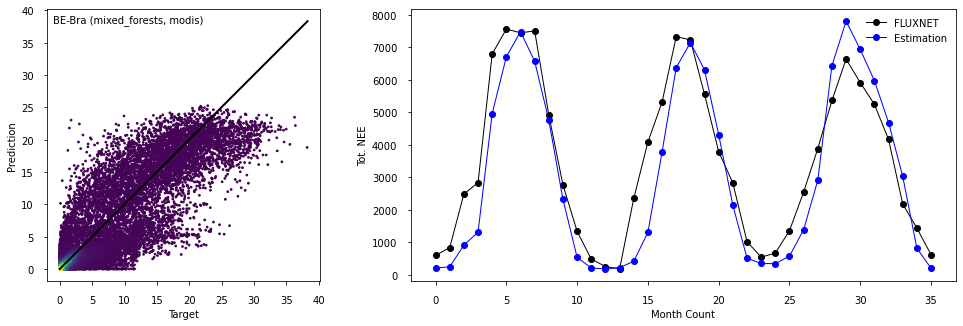

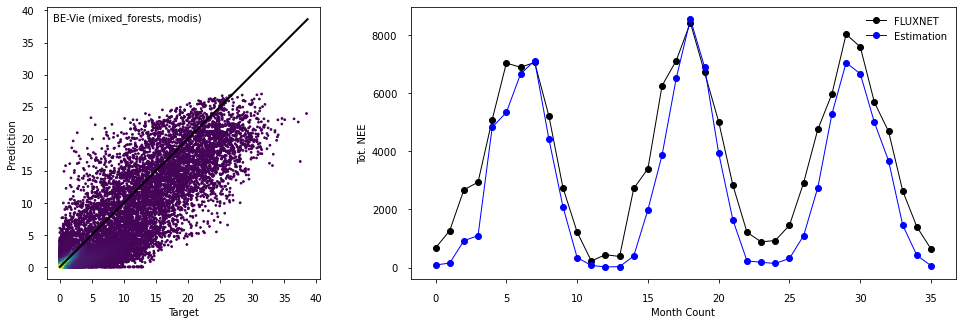

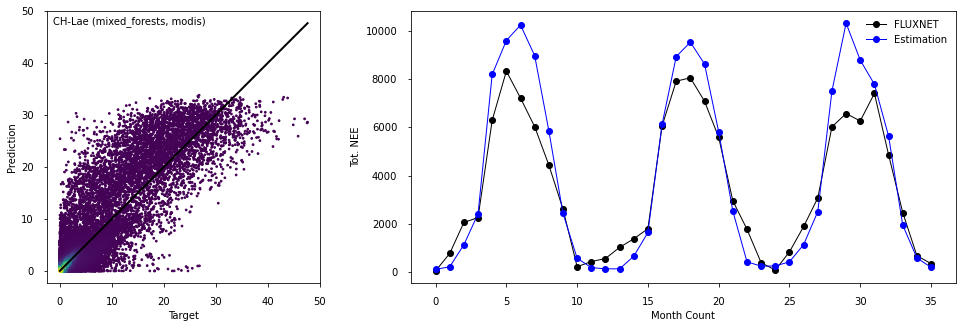

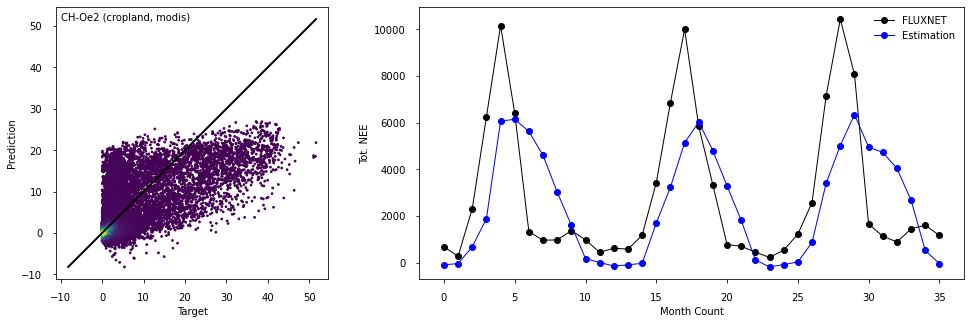

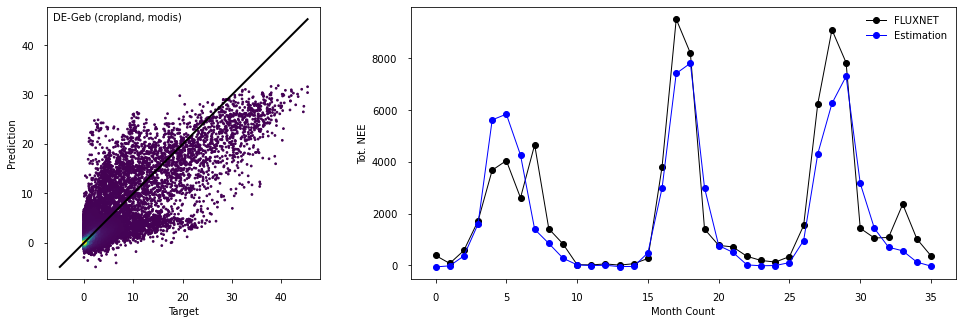

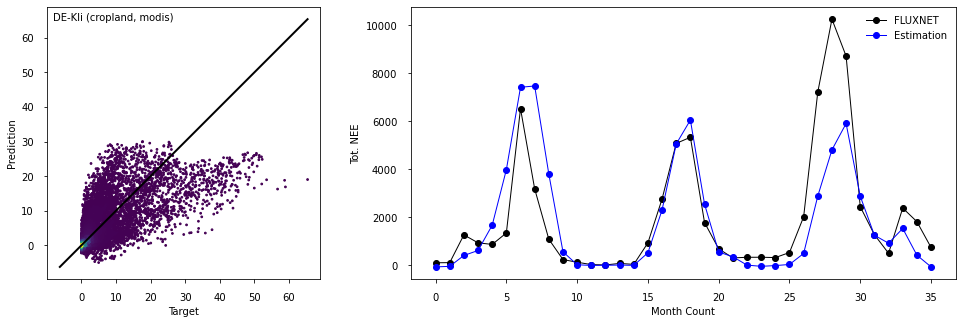

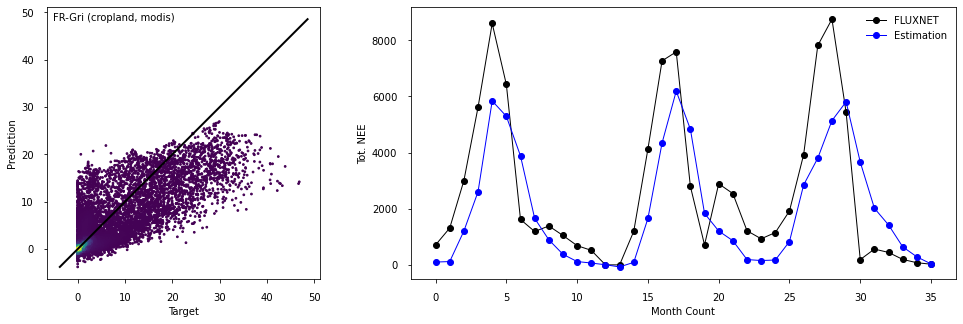

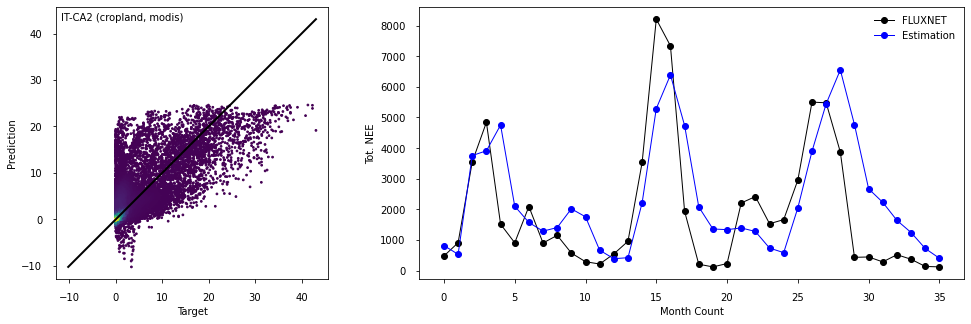

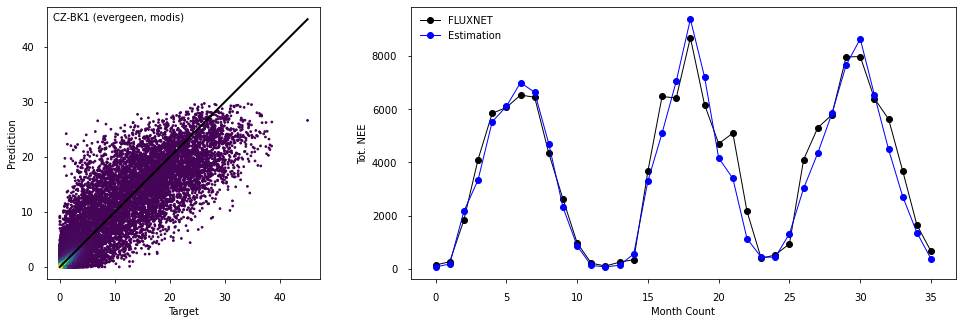

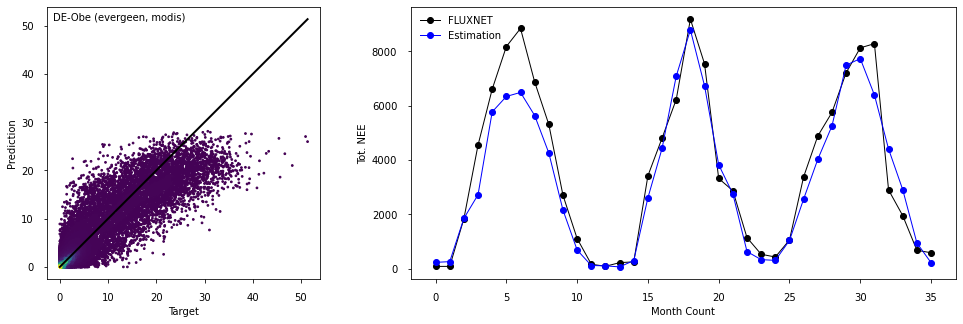

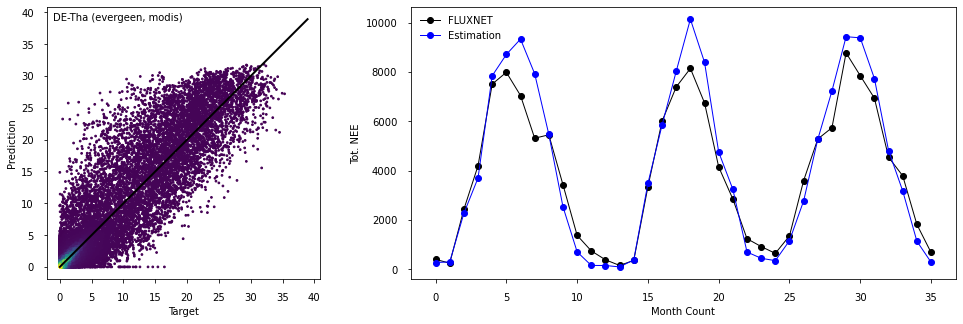

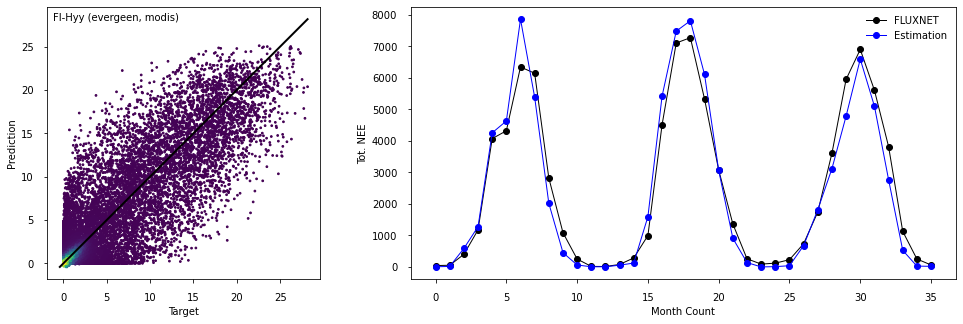

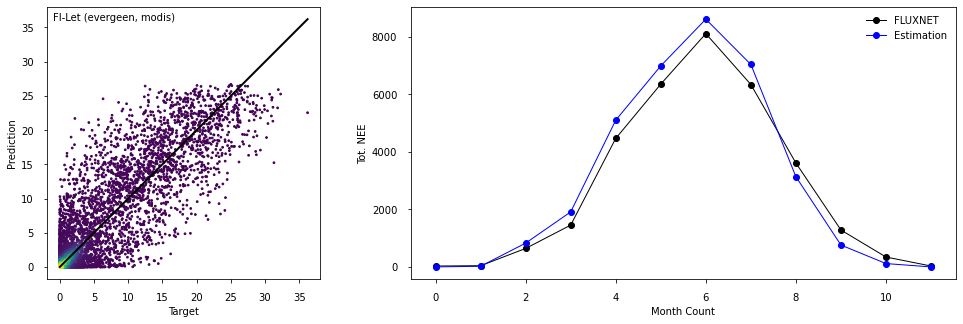

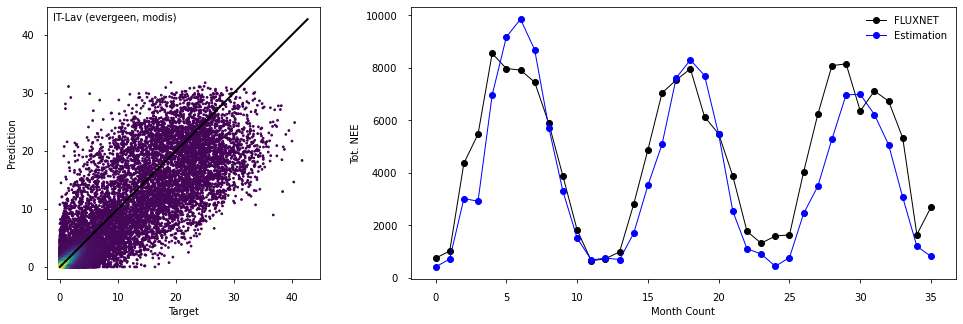

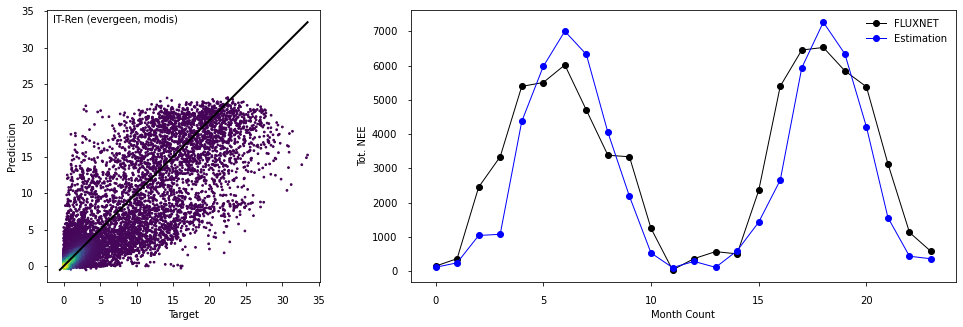

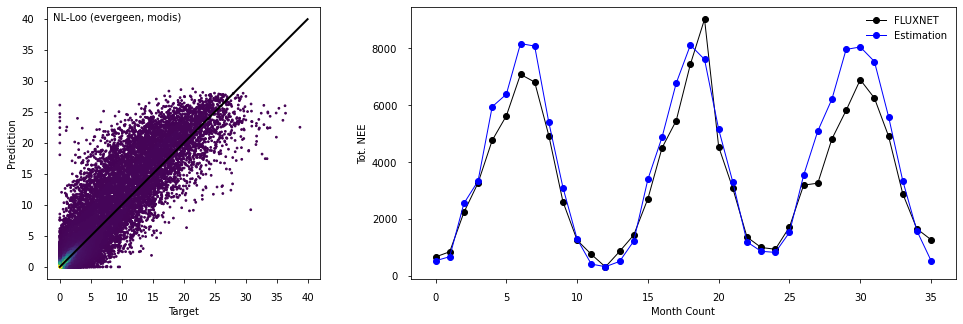

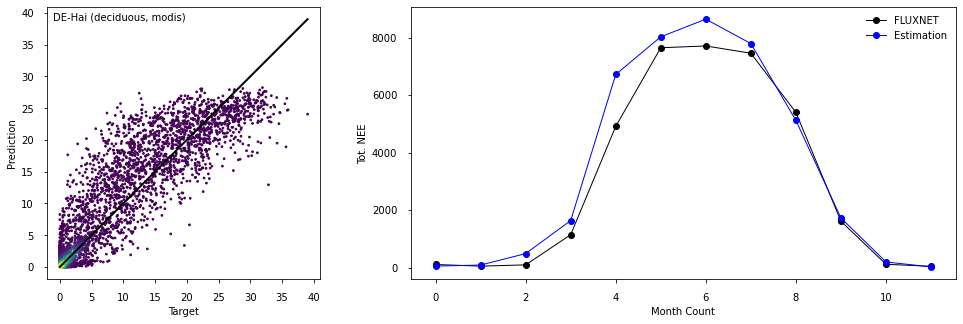

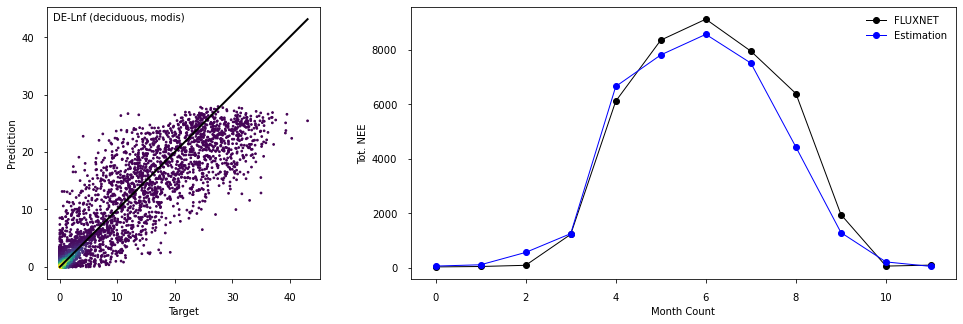

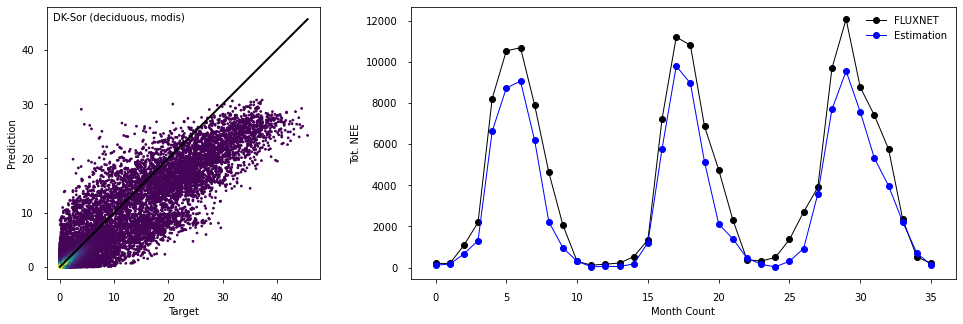

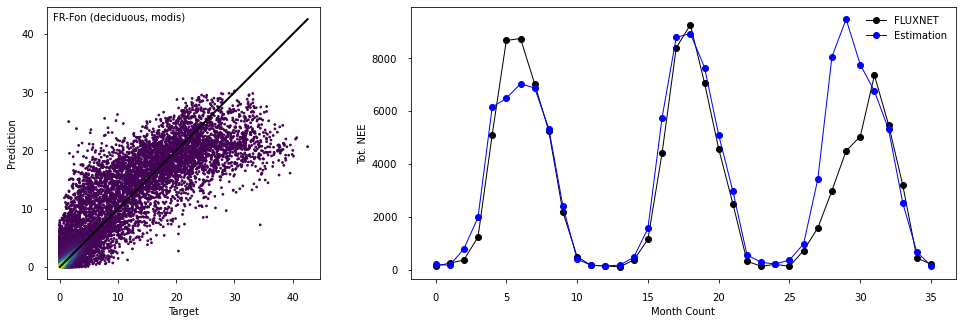

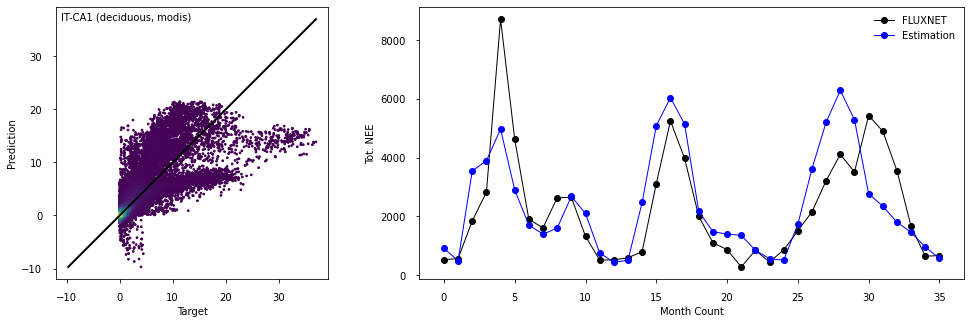

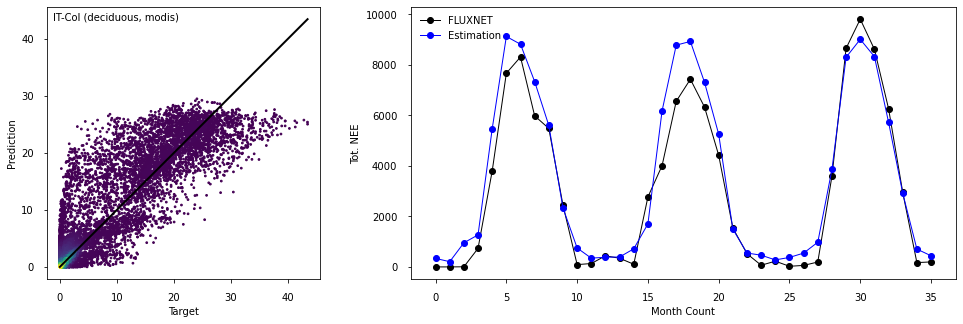

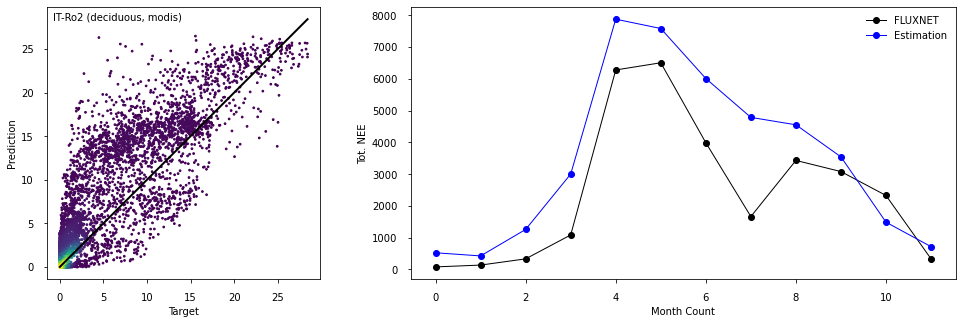

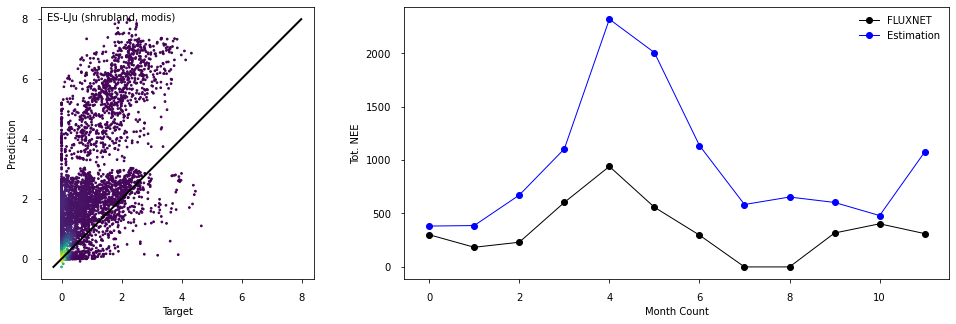

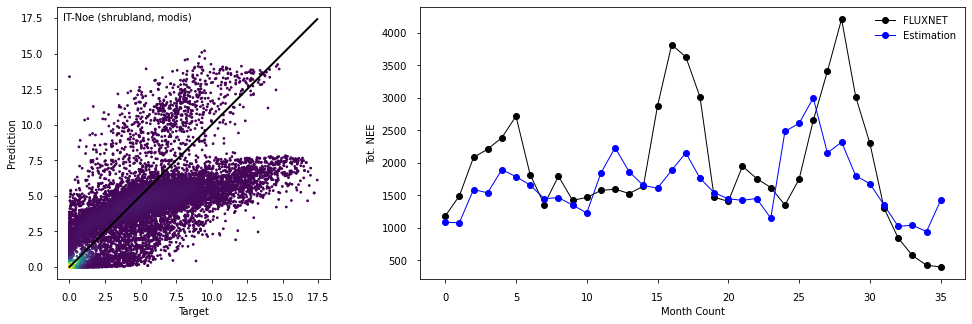

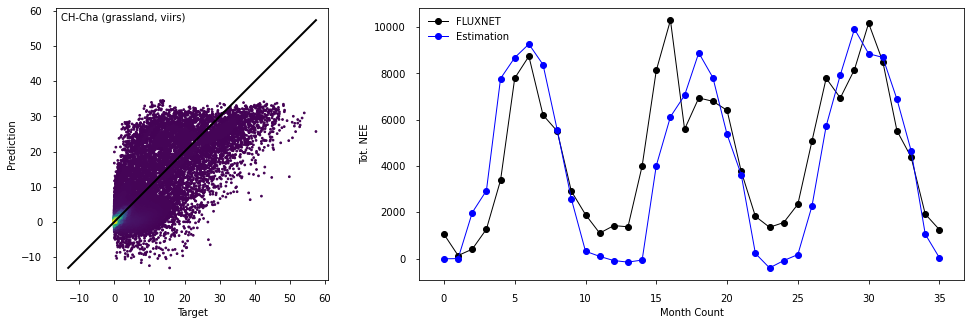

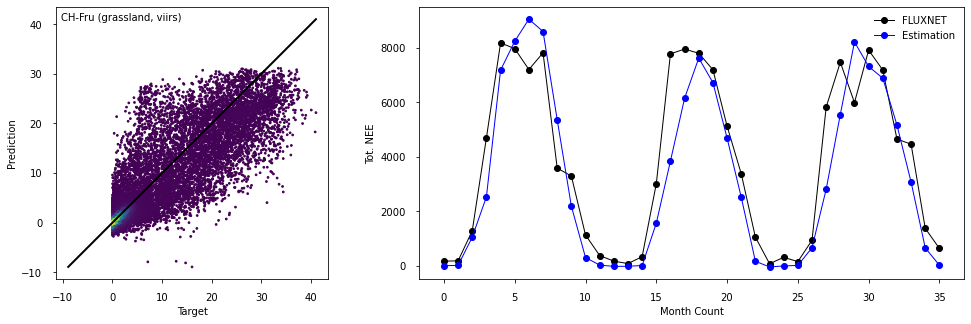

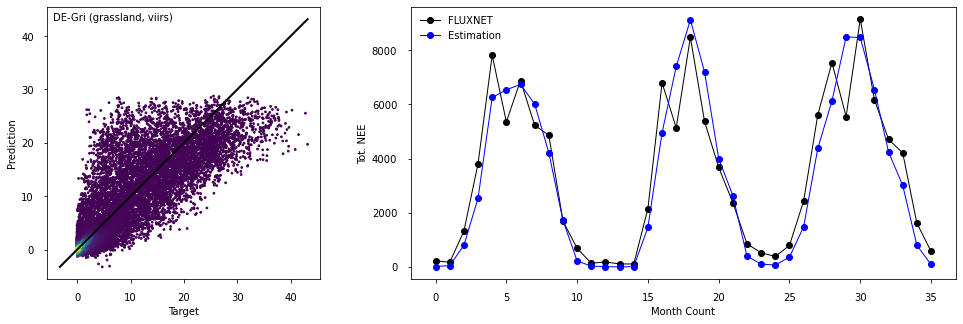

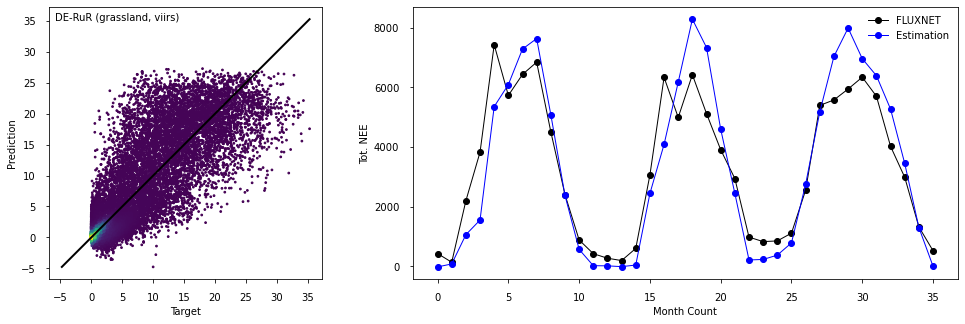

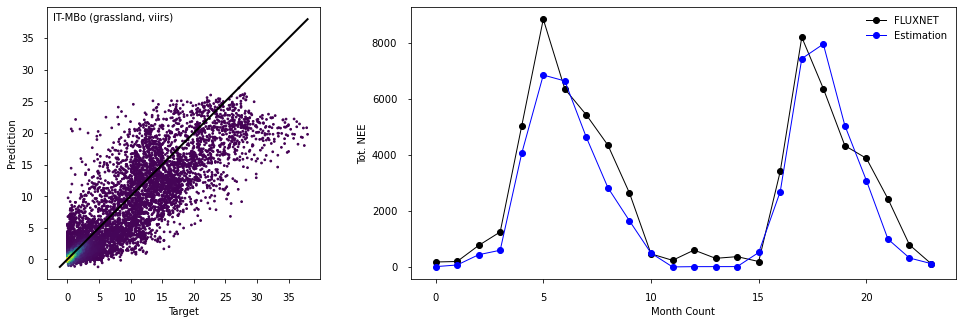

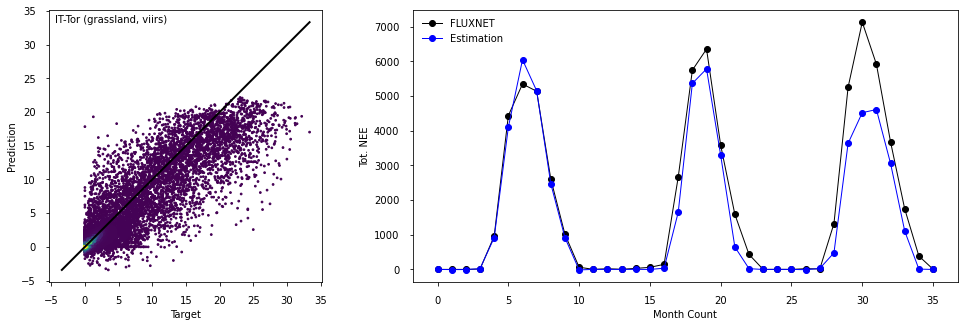

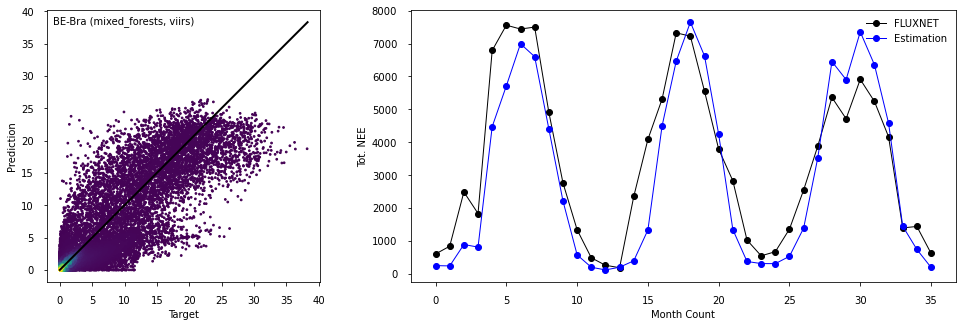

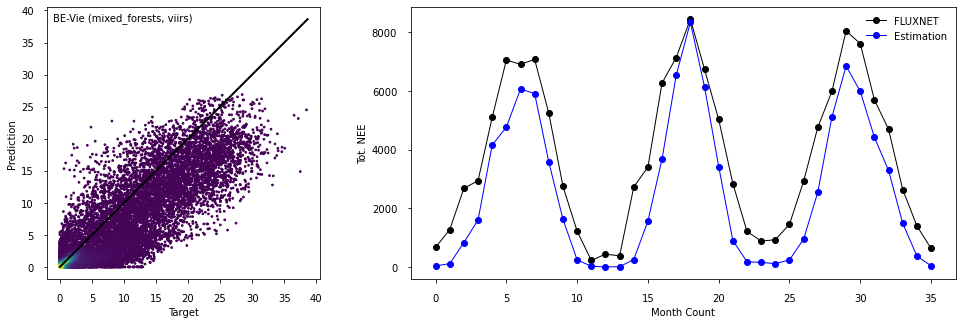

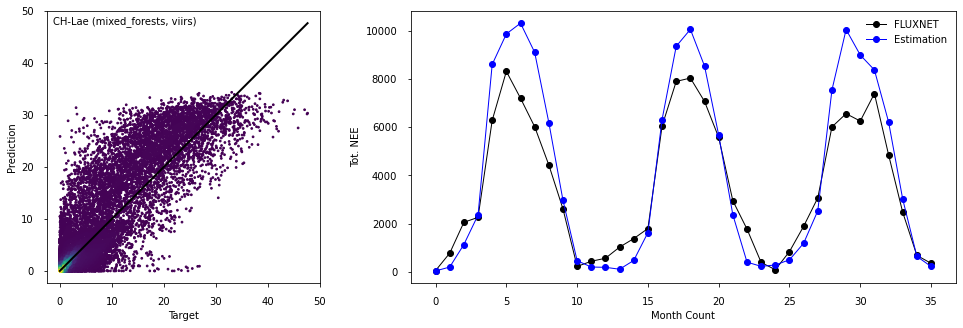

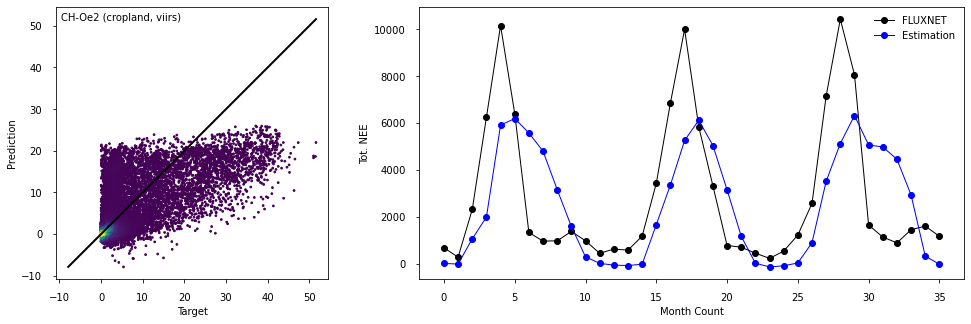

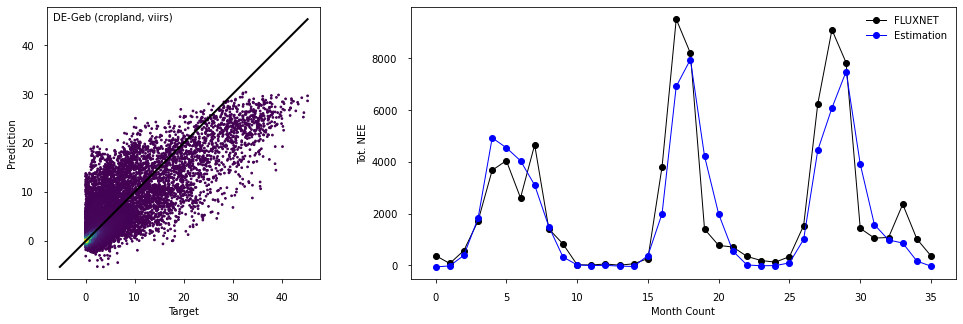

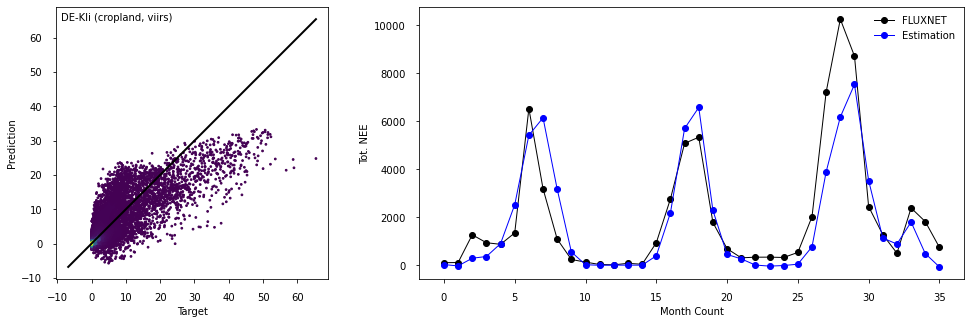

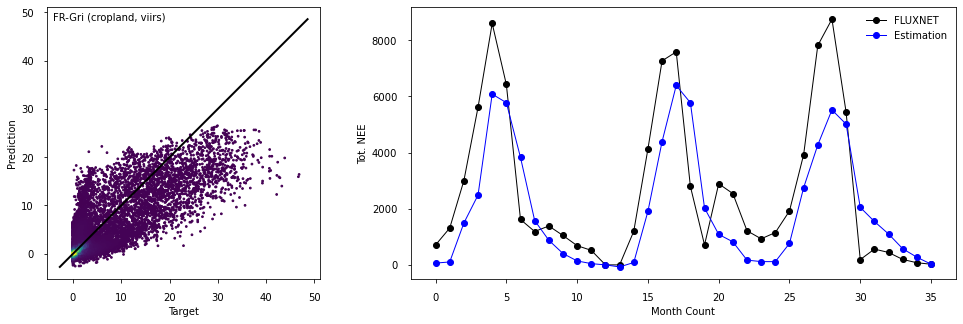

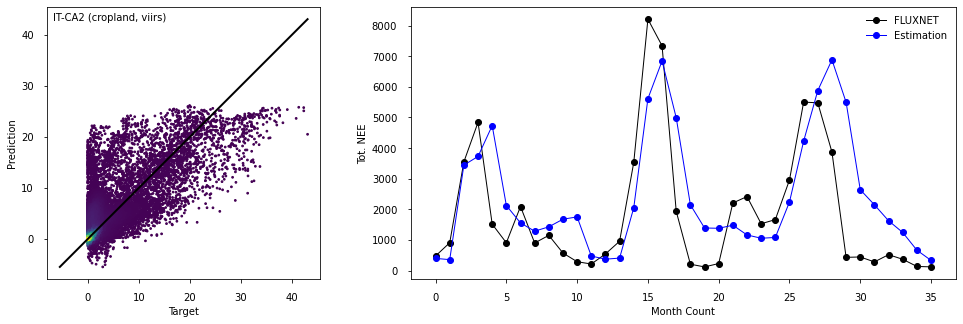

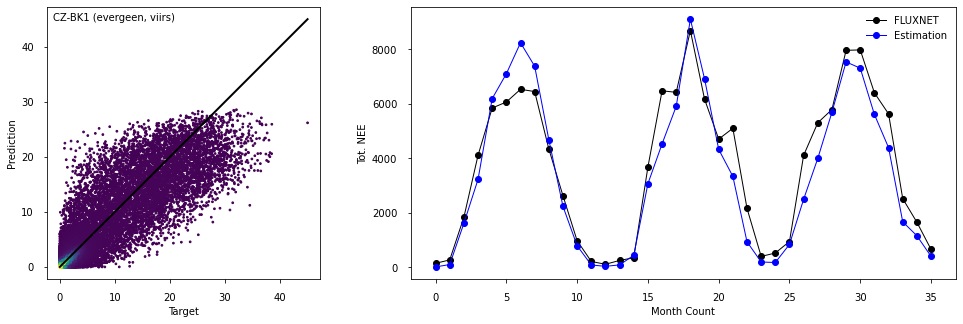

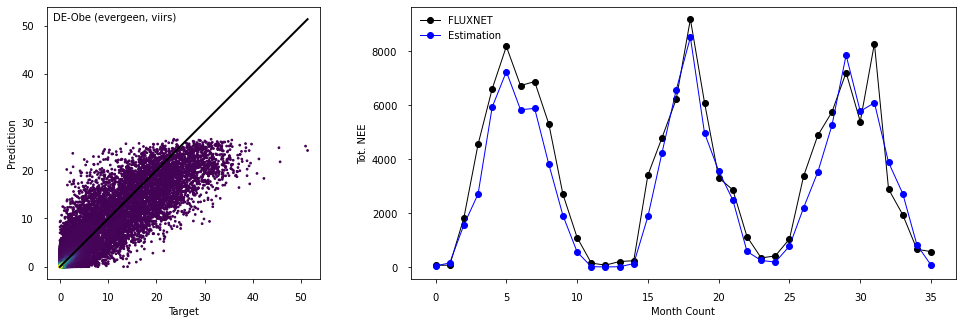

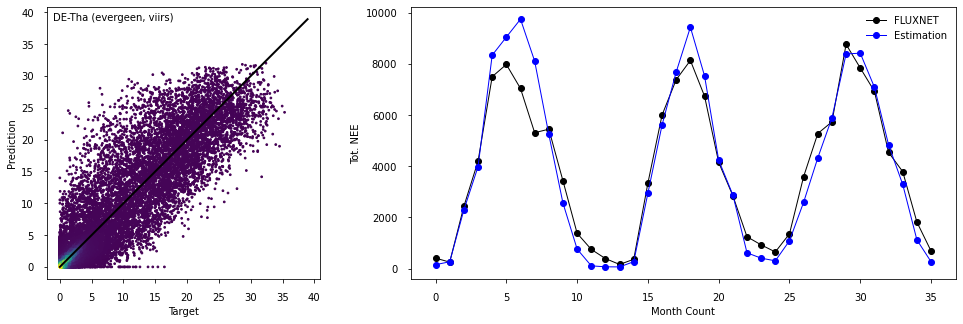

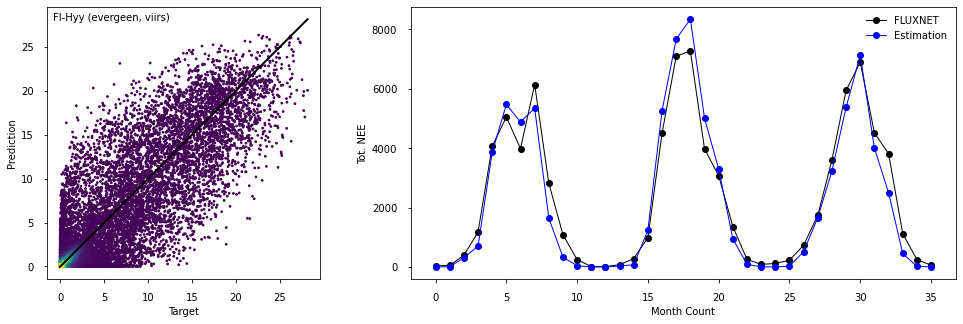

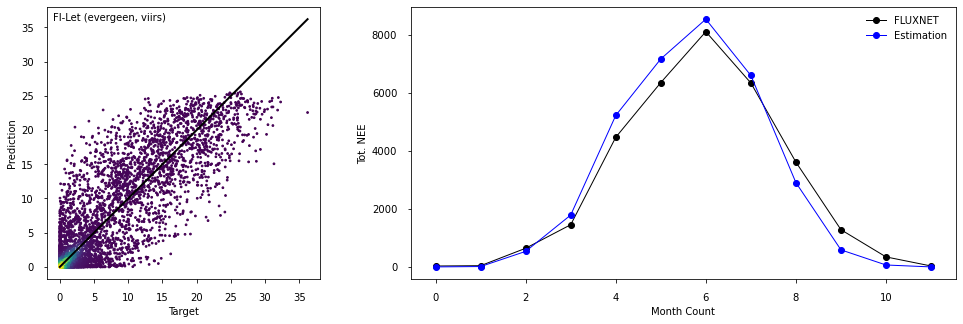

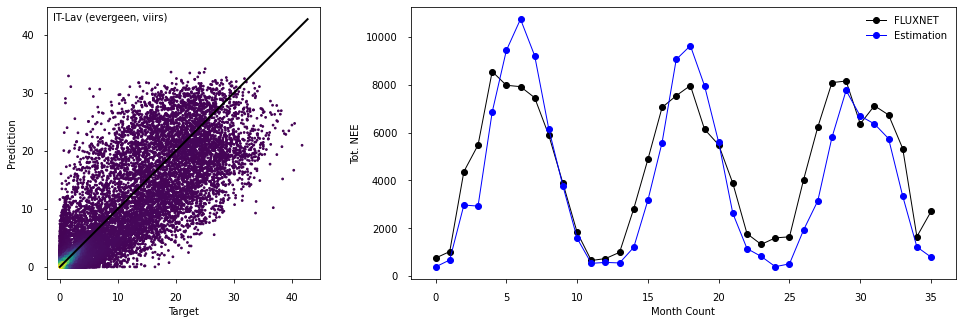

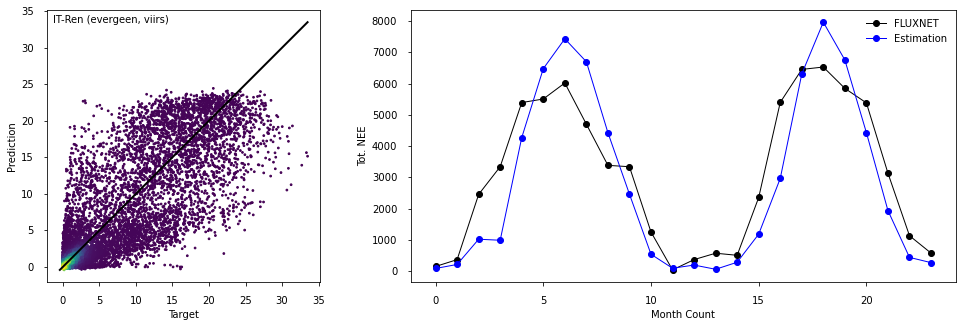

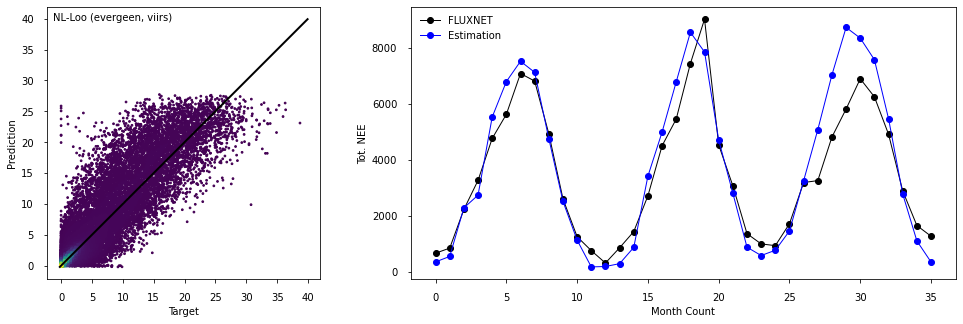

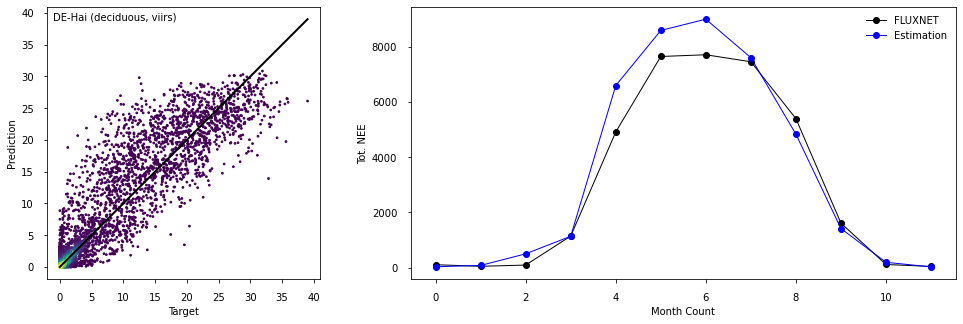

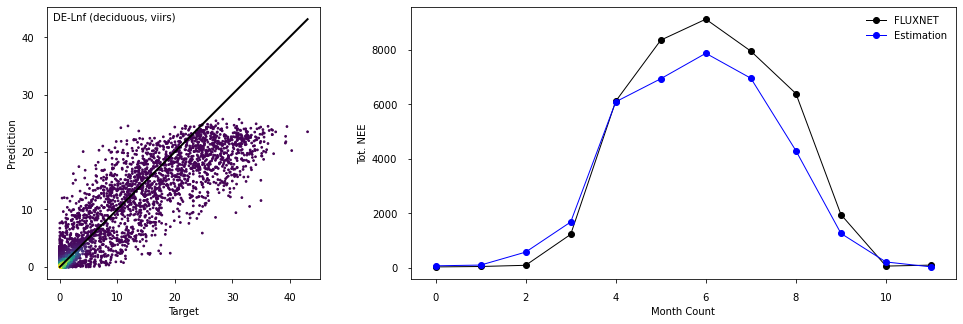

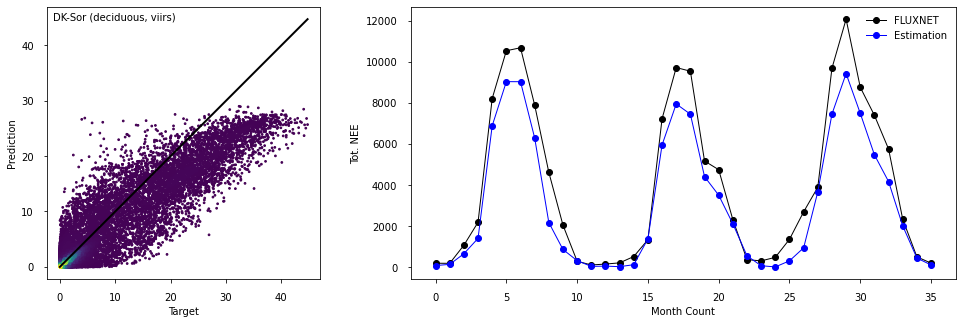

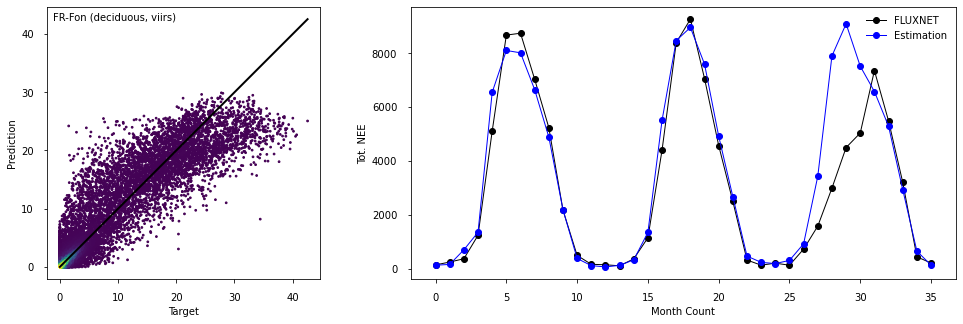

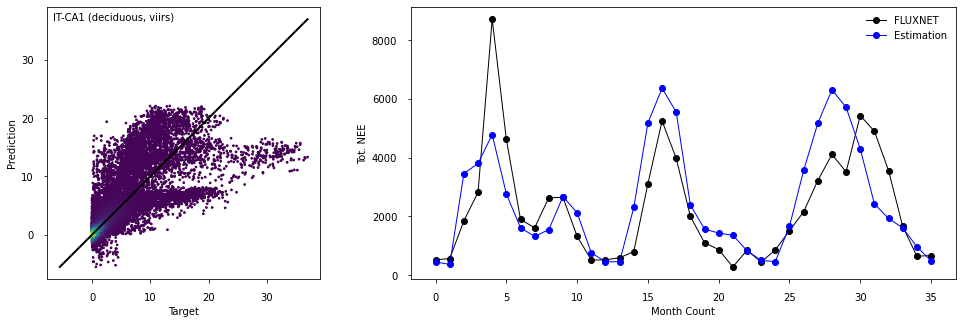

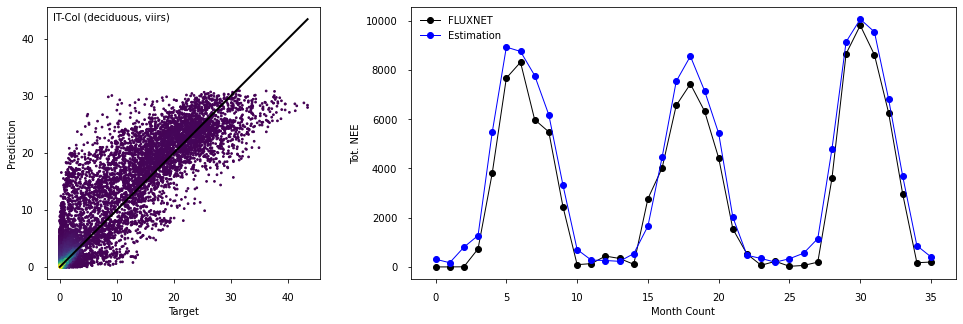

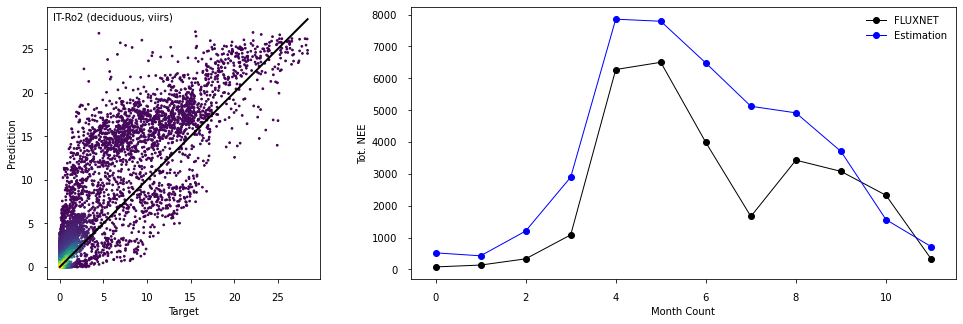

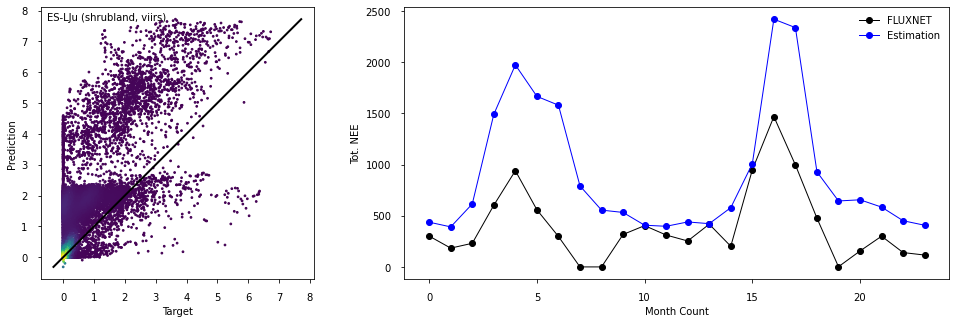

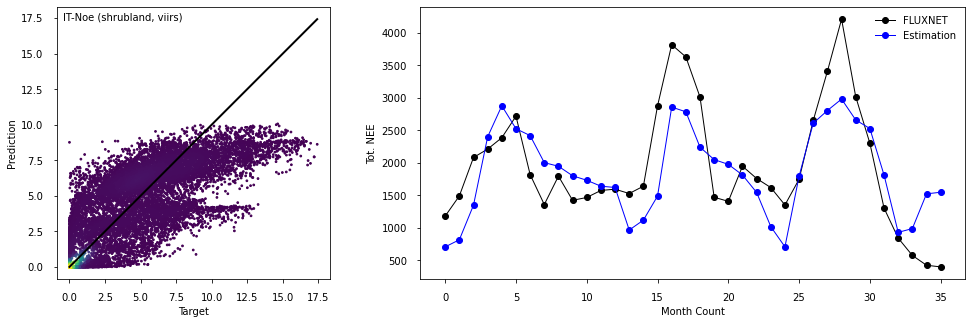

In [19]:

plots = True

mse_dict = dict()
for max_ffp in [100]:
    fit_params = dict()
    res_dict = dict()
    for key in input_data.keys():
        t_dict = dict()   
        print('-----')

        temp_dict = dict()
        mse_sub_dict = dict()

        for cvt, veg_type in enumerate(site_dict.keys()):
            # if cvt>0:
            #     continue
            print(veg_type)
            targets_gpp,  targets_nee, inputs = [], [], []
            lens = [0]
            len0 = 0

    # -------------------------- Read Data -------------------------------- 


            for site in site_dict[veg_type]:
                #print(site)
                try:
                    this_dict = copy.deepcopy(full_dict[key][veg_type][site])
                except:
                    continue
                try:
                    mh = float(site_info.loc[site_info['Site_name']==key2]['measurement_height'].values)
                    ch = float(site_info.loc[site_info['Site_name']==key2]['canopy_height'].values)
                    zm = mh - ch
                except:
                    zm = 10
                try:
                    this_dict['flxnet']['FFP'] = FFP(zm=zm, umean=this_dict['flxnet']['WS'],
                                                     h=1000, ustar=this_dict['flxnet']['USTAR'])
                    mask = (this_dict['flxnet']['NEE_VUT_REF_QC'] <= 1) & (np.abs(this_dict['flxnet']['FFP'])<max_ffp) & (np.isfinite(this_dict['flxnet']['GPP_DT_VUT_REF'])) & np.all(np.isfinite(this_dict['inputs']), axis=1)


                except Exception as e:
                    print(e)
                    print('Error')
                    continue
                this_dict['inputs'][:,2] = this_dict['flxnet']['SW_IN_F'] / 0.505
                targets_nee.extend(copy.deepcopy(this_dict['flxnet']['NEE_VUT_REF'].values)[mask])
                inputs.extend(this_dict['inputs'][mask])
                targets_gpp.extend(copy.deepcopy(this_dict['flxnet']['GPP_DT_VUT_REF'].values)[mask])
                lens.append(len(targets_gpp)-len0)
                len0 = len(targets_gpp)


            # Prepare Data
            inds = []
            lens = np.array(lens)
            targets_nee = np.array(targets_nee)
            targets_gpp = np.array(targets_gpp)
            inputs = np.array(inputs)

            if np.sum(lens) == 0:
                continue
            num_inds_per_site = np.min(lens[lens>0])
            cum_len = np.cumsum(lens)
            for i in range(len(cum_len)-1):
                if cum_len[i] == cum_len[i+1]:
                    continue
                inds.append(np.random.choice(np.arange(cum_len[i], cum_len[i+1]),
                                             num_inds_per_site))

            inds = np.concatenate(inds)  
            inputs = inputs[inds]
            targets_gpp = targets_gpp[inds]
            targets_nee = targets_nee[inds]
            # mask = targets_gpp > 0.0
            # mask_nan = np.all(np.isfinite(inputs), axis=1)
            mse_min = 1e4

            print(len(targets_gpp))
            #Make Fits
            for i in range(5):

                res_gpp_t = curve_fit(lambda x, lamb, par0: (lamb * x[:,1] * x[:,4]  * x[:,3]) * x[:,0] * x[:,2] / (1 + x[:,2]/par0),
                                inputs, targets_gpp, maxfev=5000, p0=[np.random.uniform(0,1), np.random.uniform(0,1)]) 

                spred = (res_gpp_t[0][0] * inputs[:,1] * inputs[:,4]  * inputs[:,3]) * inputs[:,0] * inputs[:,2] / (1 + inputs[:,2]/res_gpp_t[0][1])

                mse = (np.square(targets_gpp - spred)).mean()
                if mse < mse_min:
                    res_gpp = res_gpp_t
                    mse_min = mse

            print('MSE GPP:', mse_min)
            mse_min = 1e4

            for i in range(5):

                res_nee_t = curve_fit(lambda x, a,b : -(res_gpp[0][0] * x[:,1] * x[:,4]  * x[:,3]) * x[:,0] * x[:,2] / (1 + x[:,2]/res_gpp[0][1]) + a * x[:,5] + b,
                                inputs, targets_nee, maxfev=5000, p0=[np.random.uniform(0,1), np.random.uniform(0,1)])  

                spred = -(res_gpp[0][0] * inputs[:,1] * inputs[:,4]  * inputs[:,3]) * inputs[:,0] * inputs[:,2] / (1 + inputs[:,2]/res_gpp[0][1]) + res_nee_t[0][0] * (inputs[:,5])  + res_nee_t[0][1]

                mse = (np.square(targets_nee - spred)).mean()

                if mse < mse_min:
                    res_nee = res_nee_t
                    mse_min = mse
            mse_sub_dict[veg_type] = [mse, len(targets_nee), np.mean(targets_gpp)]

            print('MSE NEE:', mse_min)
            temp_dict[veg_type_id[veg_type]] = [res_gpp, res_nee]

          #  print('Make plots')
            target_key  = 'GPP_DT_VUT_REF' #'NEE_VUT_REF'  #'GPP_DT_VUT_REF' #

    # -------------------------- Plots for Cross-Checks --------------------------------  

            for site in site_dict[veg_type]:
                if plots is False:
                    continue
                try:
                    this_dict = copy.deepcopy(full_dict[key][veg_type][site])
                    mask = (this_dict['flxnet']['NEE_VUT_REF_QC'] <= 1) & (np.isfinite(this_dict['flxnet']['GPP_DT_VUT_REF'])) & np.all(np.isfinite(this_dict['inputs']), axis=1)
                except:
                    continue
                this_dict['flxnet']['FFP'] = FFP(zm=10, umean=this_dict['flxnet']['WS'],
                                                 h=1000, ustar=this_dict['flxnet']['USTAR'])
           #     this_dict['inputs'][:,2] = this_dict['flxnet']['SW_IN_F'] / 0.505
                ws_mask = np.abs(this_dict['flxnet']['FFP'])<10
                spred, targets, tmsp = make_prediction_for_site(this_dict, target_key, res_gpp, res_nee)
                if spred is None:
                    continue
                ax_max = np.max([spred[np.isfinite(spred)], targets[np.isfinite(spred)]])
                ax_min = np.min([spred[np.isfinite(spred)], targets[np.isfinite(spred)]])
                t_dict[site] = [spred[mask], targets[mask], np.array(tmsp)[mask]]


#                 fig, ax = newfig(0.9,ratio=1.0)
#                 ax.hist(this_dict['inputs'][:,2] - this_dict['flxnet']['SW_IN_F']/0.505, bins=100)
#                 ax.set_xlabel('Target')
#                 ax.set_ylabel('Prediction')
#                 ax.text(0.1, 0.9, site,
#                   horizontalalignment='left',
#                   verticalalignment='top',
#                   transform = ax.transAxes)
#                 ax.plot([ax_min, ax_max], [ax_min, ax_max], color='k',
#                      lw=2)
#                 fig.show()


                # Plot 1
                fig = plt.figure(figsize=figsize(2.0, ratio=0.3))#newfig(1.2,ratio=0.3)
                ax = fig.add_axes((0.0, 0.0, 0.3, 1.0))
                xy = np.vstack([targets[mask], spred[mask]])
                z = gaussian_kde(xy)(xy)
                ax.scatter(targets[mask], spred[mask], s=3, c=z)
             #   ax.scatter(targets[mask & ws_mask], spred[mask & ws_mask], s=3, color='red')
                ax.set_xlabel('Target')
                ax.set_ylabel('Prediction')
                ax.text(0.02, 0.98, '{} ({}, {})'.format(site, veg_type, key),
                  horizontalalignment='left',
                  verticalalignment='top',
                  transform = ax.transAxes)
                ax.plot([ax_min, ax_max], [ax_min, ax_max], color='k',
                     lw=2)
                
                month_values_pred = []
                temp_values_pred = [] 
                month_values_truth = []
                temp_values_truth = [] 
                c_month = tmsp[0].month
                for c, i in enumerate(tmsp):
                    if i.month != c_month:
                        c_month = i.month
                        # print(site, i.month, len(temp_values_pred), np.mean(temp_values_pred))
                        month_values_pred.append(np.sum(np.array(temp_values_pred)[np.isfinite(temp_values_pred)]))
                        month_values_truth.append(np.sum(np.array(temp_values_truth)[np.isfinite(temp_values_pred)]))
                        temp_values_truth = [] 
                        temp_values_pred = []
                    temp_values_pred.append(spred[c])
                    temp_values_truth.append(targets[c])
                    
                ax2 = fig.add_axes((0.4, 0.0, 0.6, 1.0))
                ax2.plot(range(len(month_values_truth)), month_values_truth, color='k',
                     marker='o', label='FLUXNET')
                ax2.plot(range(len(month_values_pred)), month_values_pred, color='b',
                 marker='o', label='Estimation')
                ax2.legend(loc='best', frameon=False)
                ax2.set_ylabel('Tot. NEE')
                ax2.set_xlabel('Month Count')
                fig.show()
                
                fig.savefig('/work/bd1231/tglauch/plots/{}_{}.jpg'.format(key, site), dpi=300,
                            bbox_inches='tight')

                # # Plot 2
                # fig, ax = newfig(2.0, ratio=0.3)
                # ax.plot(range(len(targets)), targets, lw=1, color='k',
                #      marker='o', ms=1)
                # ax.plot(range(len(spred)), spred, lw=1,
                #      marker='o', ms=1)
                # ax.text(0.1, 0.9, site,
                #   horizontalalignment='left',
                #   verticalalignment='top',
                # transform = ax.transAxes)
                # ax.set_xlim(3000,3500)
                # fig.show()


            res_dict[key] = t_dict
        fit_params[key] = temp_dict
    mse_dict[max_ffp] = mse_sub_dict

In [19]:
mse_dict

{30: {'grassland': [20.292729915201722, 42049, 4.925161827819925],
  'mixed_forests': [21.67220995026697, 59418, 5.505107758625332],
  'cropland': [19.737023692945364, 37320, 4.2204686713558415],
  'evergeen': [11.73704581664388, 69520, 4.62426253816168],
  'deciduous': [12.401154166561982, 39354, 5.1788802367993085],
  'shrubland': [2.5982932488221446, 16058, 1.8123712296051813]}}

In [20]:
for k in ['modis']:
    o_dict = dict()
    for vkey in sorted(fit_params[k]):
        o_dict[vkey] = dict(zip(['lamb', 'par0', 'alpha', 'beta'], list(np.concatenate([fit_params[k][vkey][0][0], fit_params[k][vkey][1][0]]))))
 #   with open('/home/b/b309233/{}.pickle'.format(k), 'w+b') as ofile:
 #       pickle.dump(o_dict, ofile)
    print(o_dict)

{1: {'lamb': 0.19743327068419783, 'par0': 482.87660138380284, 'alpha': 0.2867682881176401, 'beta': 0.1926588145766841}, 2: {'lamb': 0.14833857796044297, 'par0': 377.08339121045066, 'alpha': 0.16514173670621773, 'beta': 1.127244584999253}, 3: {'lamb': 0.15856727431095263, 'par0': 431.9495742641569, 'alpha': 0.2750043205436562, 'beta': 0.17398391394383078}, 4: {'lamb': 0.11432027637735678, 'par0': 633.7245804044201, 'alpha': 0.09802688249369683, 'beta': -0.17343891629748678}, 6: {'lamb': 0.0984418893228436, 'par0': 733.1953770728318, 'alpha': 0.2844891522194532, 'beta': -0.8767987837109943}, 7: {'lamb': 0.1447813590832068, 'par0': 489.5848514058355, 'alpha': 0.4516670221110187, 'beta': -0.39016680169495876}}


In [30]:
o_dict

{1: {'lamb': 0.20247042012461533,
  'par0': 462.05592641383186,
  'alpha': 0.2823224304523287,
  'beta': 0.19225294276014498},
 2: {'lamb': 0.14493118123533535,
  'par0': 392.1728784758664,
  'alpha': 0.16740451251849256,
  'beta': 1.106279862724718},
 3: {'lamb': 0.1568772316130086,
  'par0': 439.2554616167214,
  'alpha': 0.2730625300220306,
  'beta': 0.195240458063079},
 4: {'lamb': 0.11320501342782781,
  'par0': 637.9351023615932,
  'alpha': 0.09785337747519694,
  'beta': -0.16192915802690255},
 6: {'lamb': 0.09859513835342838,
  'par0': 720.4430758476603,
  'alpha': 0.2837873307575456,
  'beta': -0.8827343112325297},
 7: {'lamb': 0.14364651339106896,
  'par0': 498.14464361473546,
  'alpha': 0.45373254317659406,
  'beta': -0.41334470205342466}}

In [14]:
# with open('/home/b/b309233/fit_res_modis.pickle', 'w+b') as ofile:
#     pickle.dump(fit_res_dict_modis, ofile)

In [44]:
# res_dict['modis'].keys()

dict_keys(['AT-Neu', 'CH-Cha', 'CH-Fru', 'CZ-BK2', 'DE-Gri', 'DE-RuR', 'IT-MBo', 'IT-Tor', 'BE-Bra', 'BE-Vie', 'CH-Lae', 'BE-Lon', 'CH-Oe2', 'DE-Geb', 'DE-Kli', 'DE-RuS', 'FR-Gri', 'IT-BCi', 'IT-CA2', 'CH-Dav', 'CZ-BK1', 'DE-Lkb', 'DE-Obe', 'DE-Tha', 'FI-Hyy', 'FI-Let', 'FI-Sod', 'IT-Lav', 'IT-Ren', 'IT-SRo', 'NL-Loo', 'RU-Fyo', 'DE-Hai', 'DE-Lnf', 'DK-Sor', 'FR-Fon', 'IT-CA1', 'IT-CA3', 'IT-Col', 'IT-Ro2', 'ES-Amo', 'ES-LJu', 'IT-Noe'])

In [45]:
# res_dict['modis']['IT-CA2'][1][500:520]

array([0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.420049, 0.684954, 1.90169 , 2.03509 , 1.78827 , 3.40159 ,
       3.30173 , 1.64169 ])

In [43]:
# res_dict['modis']['CH-Fru'][1][500:520]

array([0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.050745, 0.17656 , 0.240094, 0.228162, 0.21309 ,
       0.192168, 0.16227 ])

AT-Neu
CH-Cha
CH-Fru
DE-Gri
DE-RuR
IT-MBo
IT-Tor
BE-Bra
BE-Vie
CH-Lae
CH-Oe2
DE-Geb
DE-Kli
FR-Gri
IT-BCi
IT-CA2
CH-Dav
CZ-BK1
DE-Lkb
DE-Obe
DE-Tha


/tmp/ipykernel_749092/3392780711.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize(2.0, ratio=0.3))


FI-Hyy
FI-Let
IT-Lav
IT-Ren
NL-Loo
DE-Hai
DE-Lnf
DK-Sor
FR-Fon
IT-CA1
IT-Col
IT-Ro2
ES-LJu
IT-Noe


/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


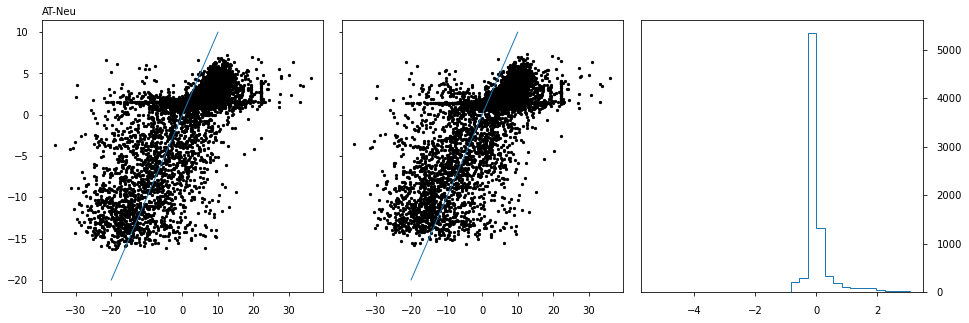

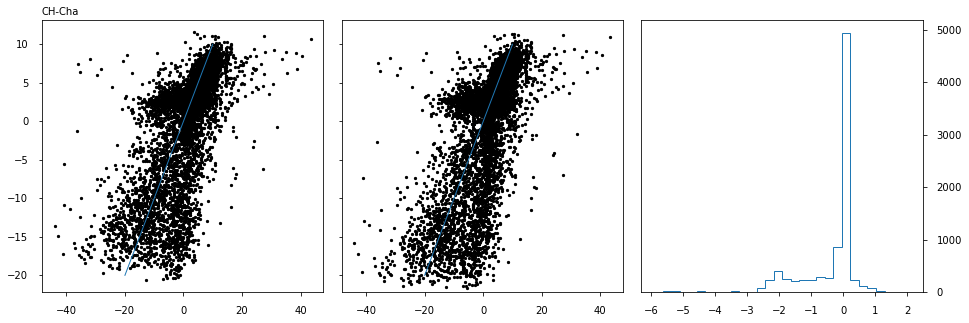

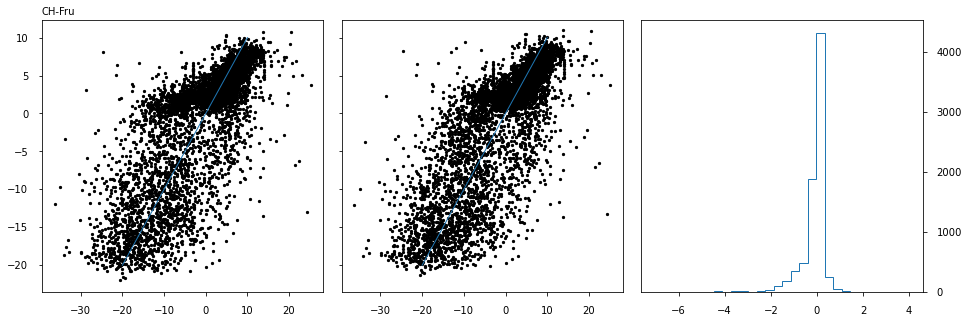

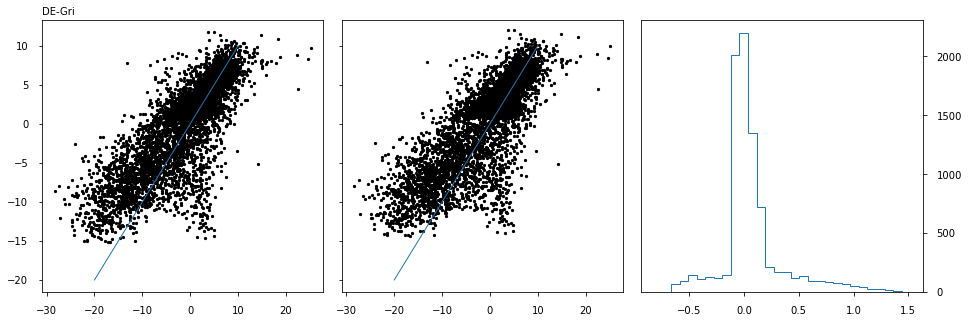

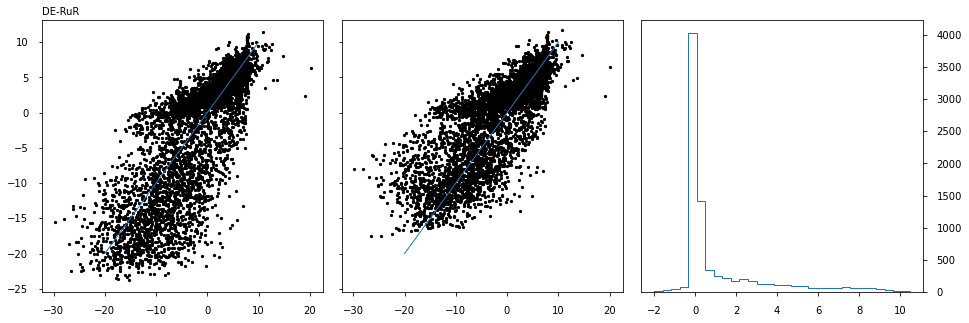

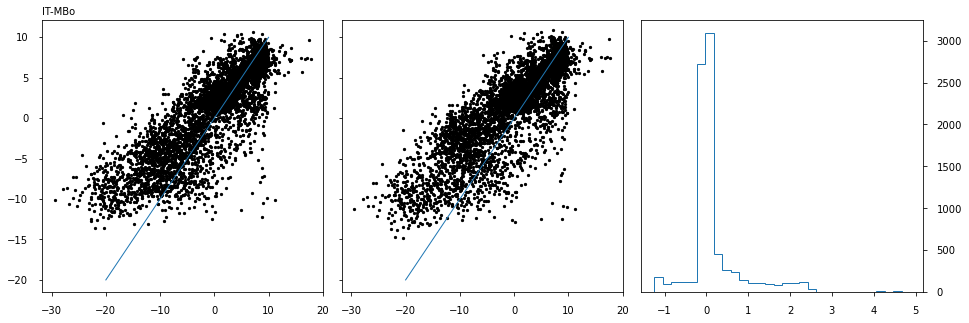

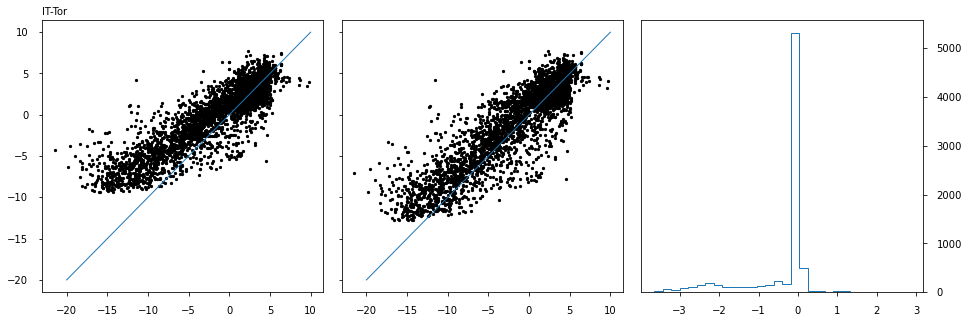

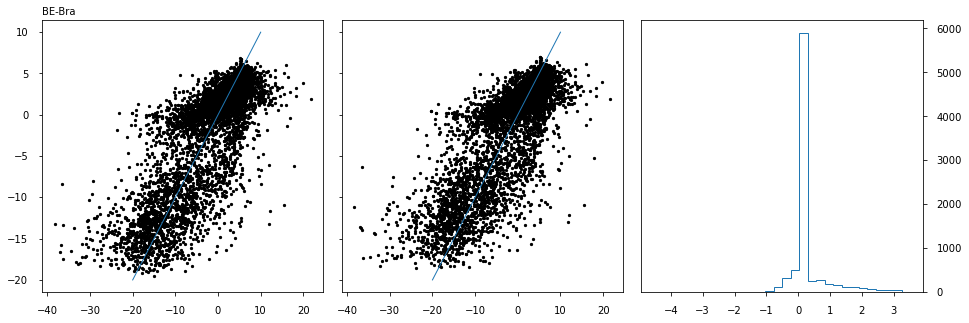

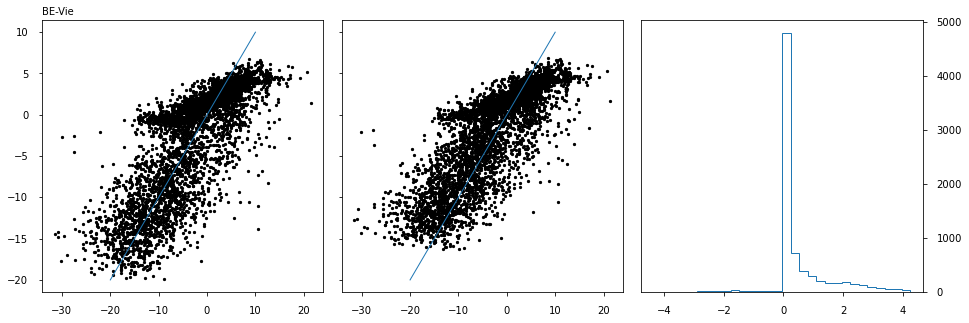

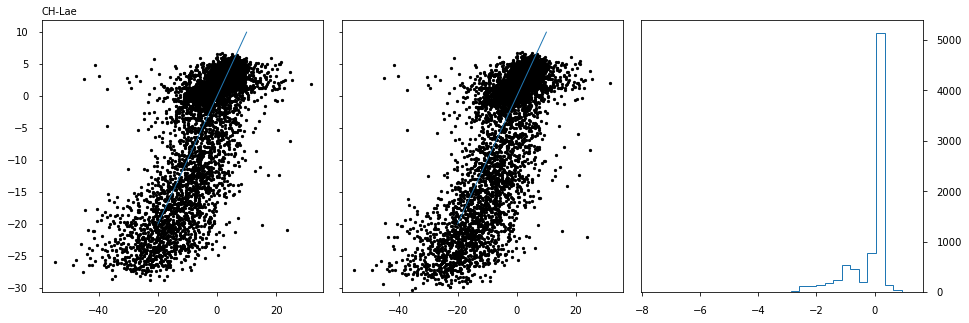

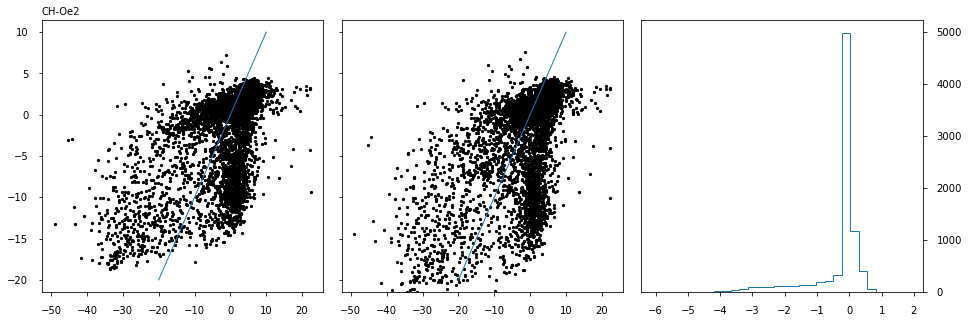

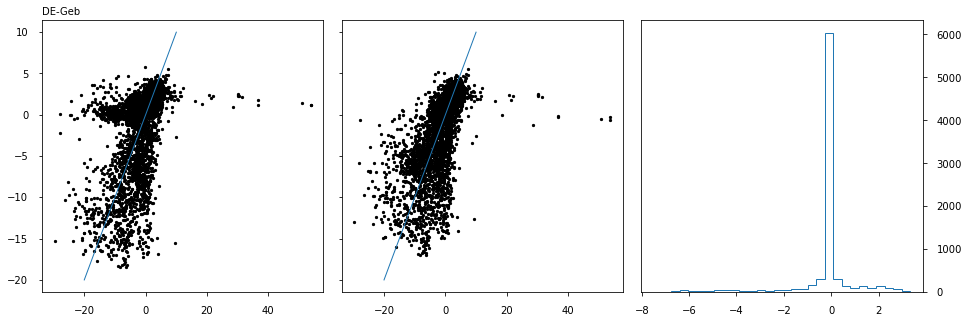

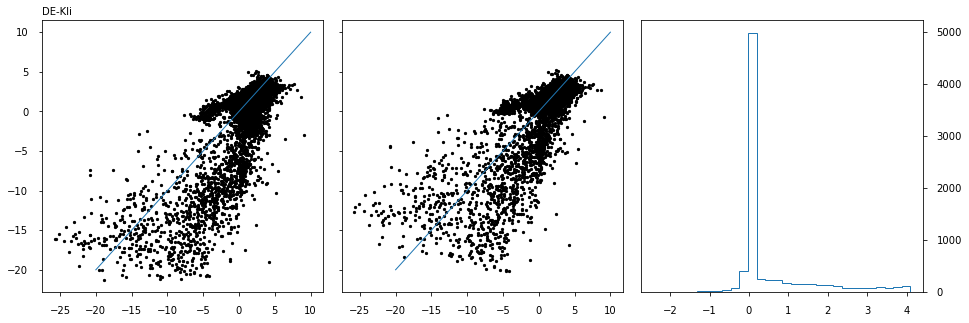

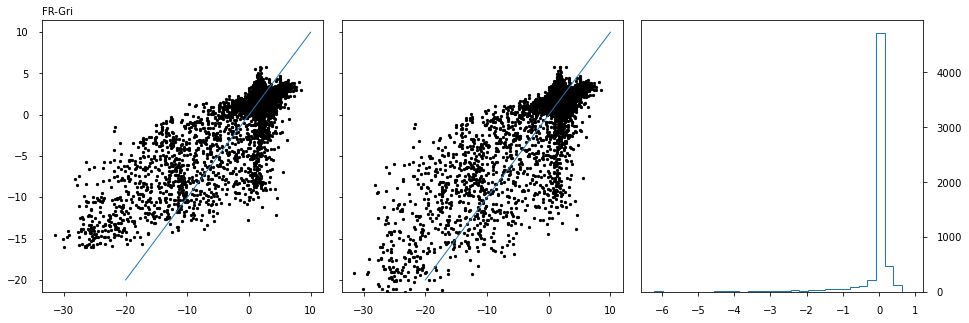

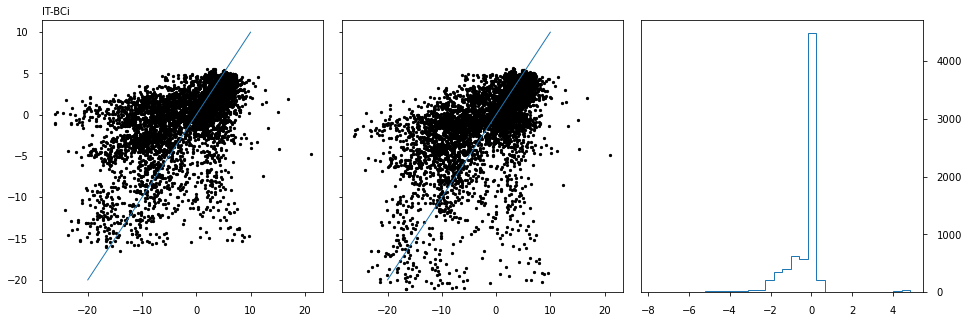

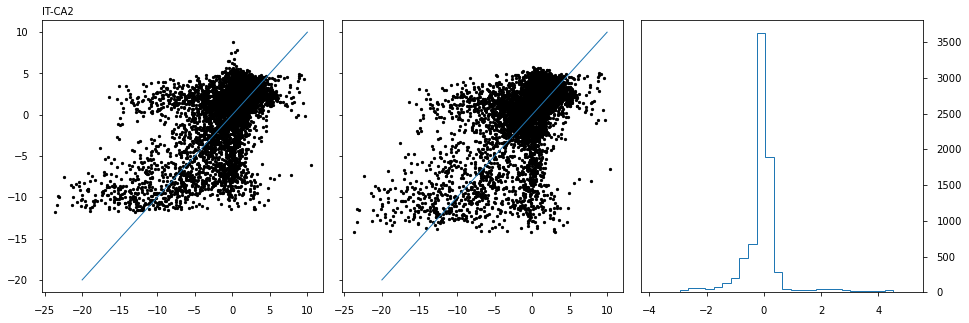

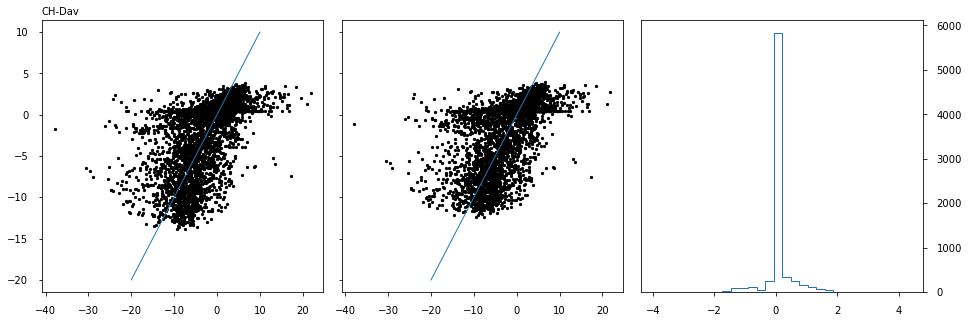

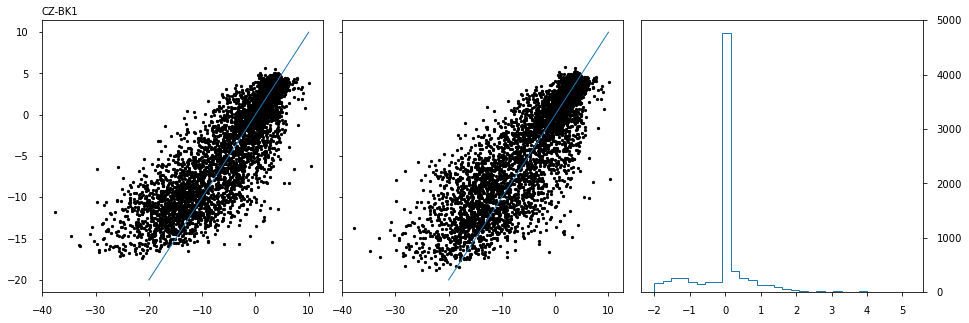

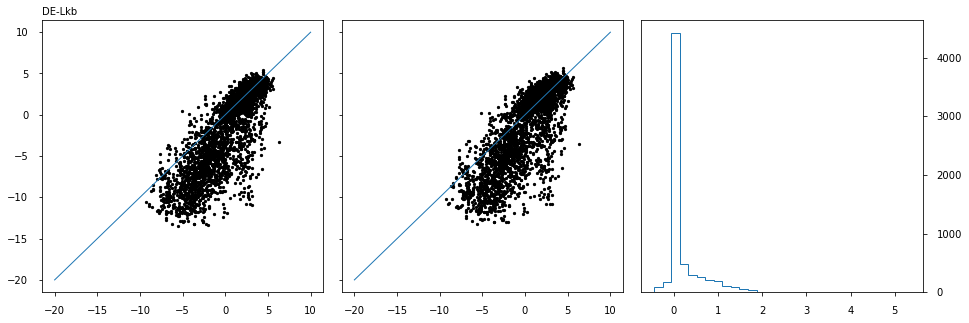

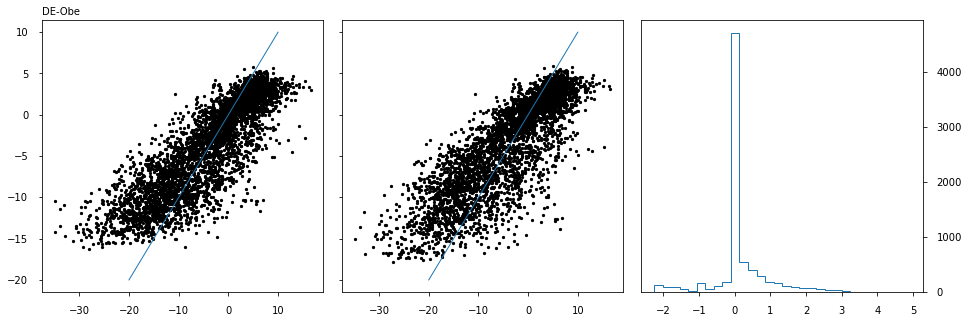

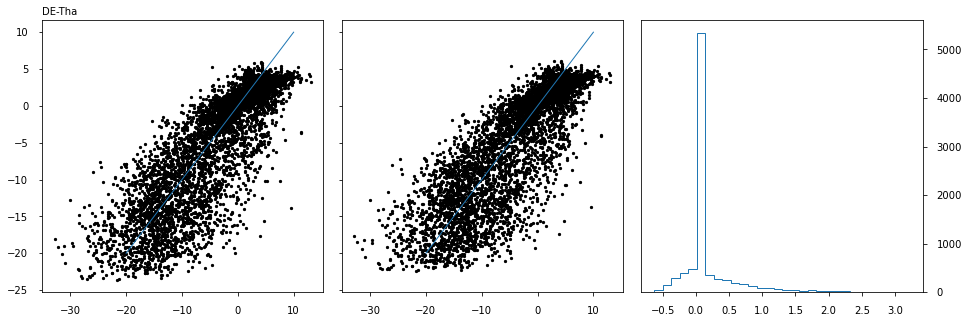

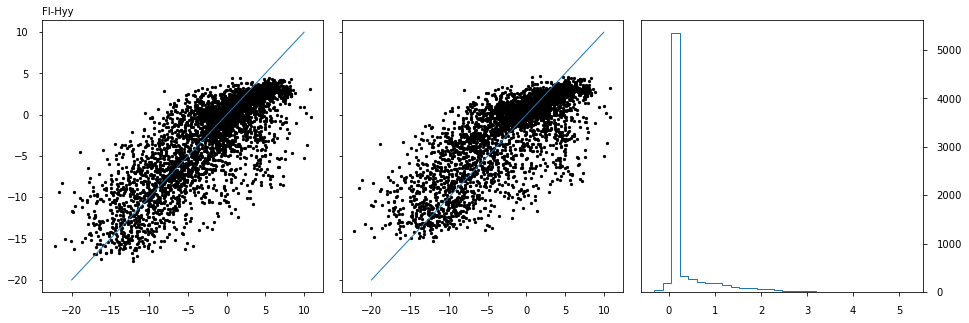

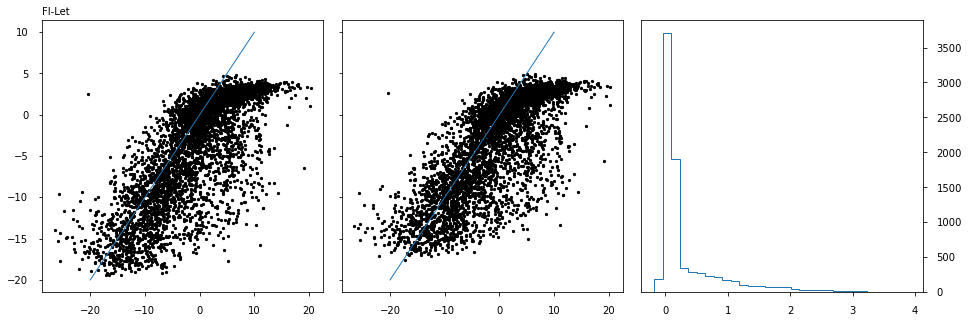

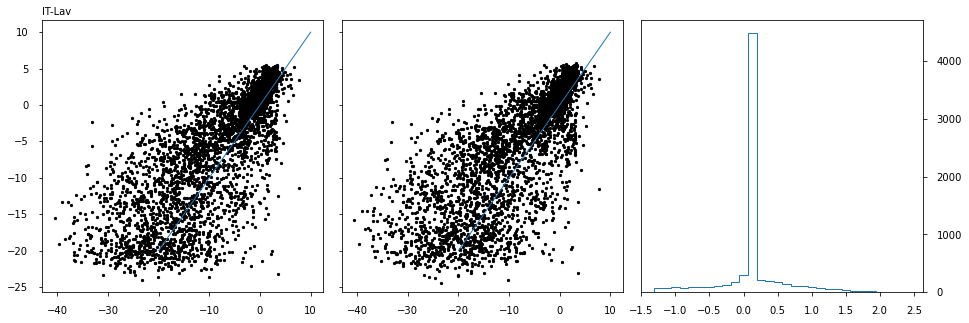

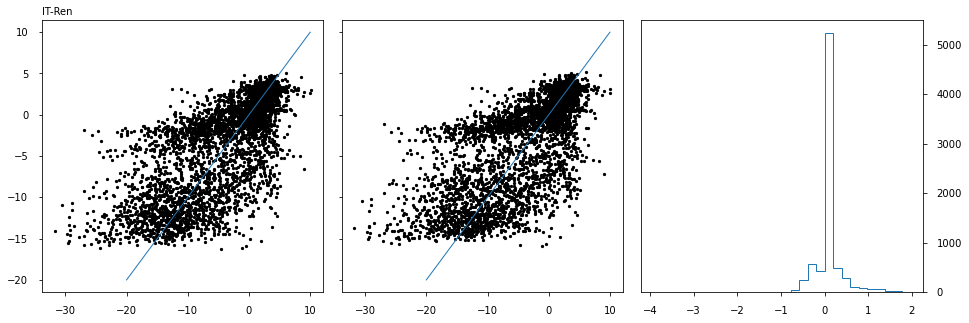

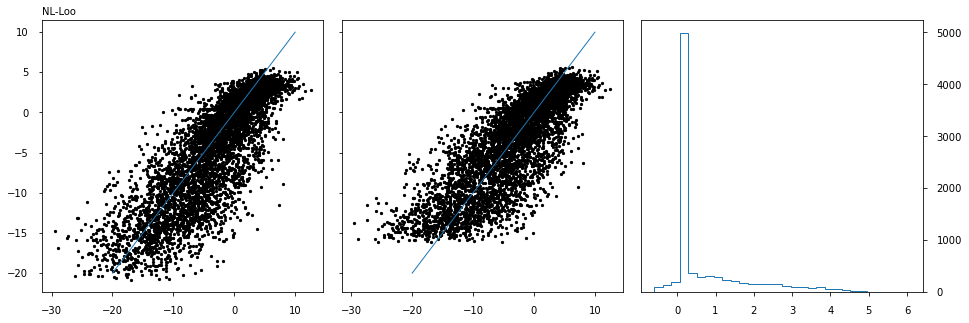

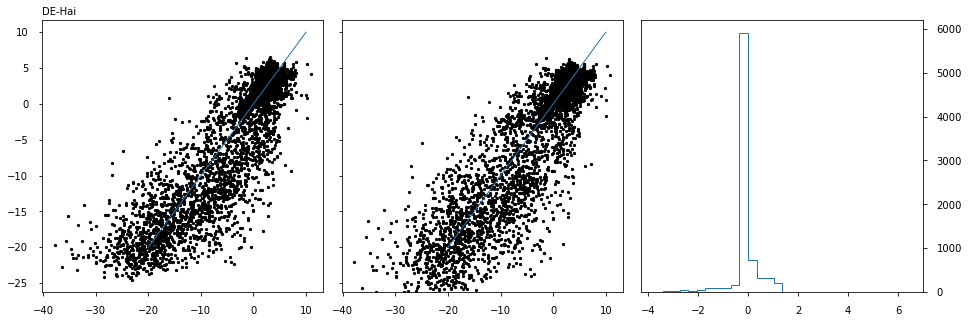

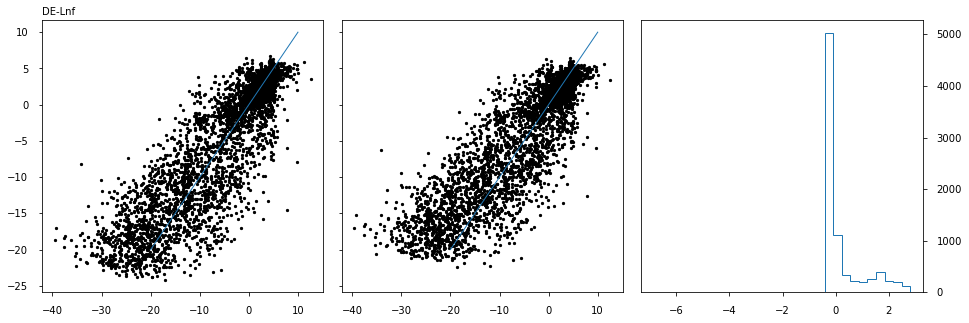

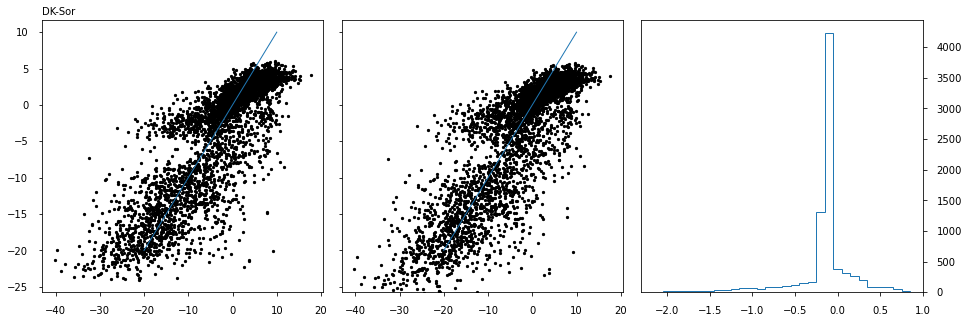

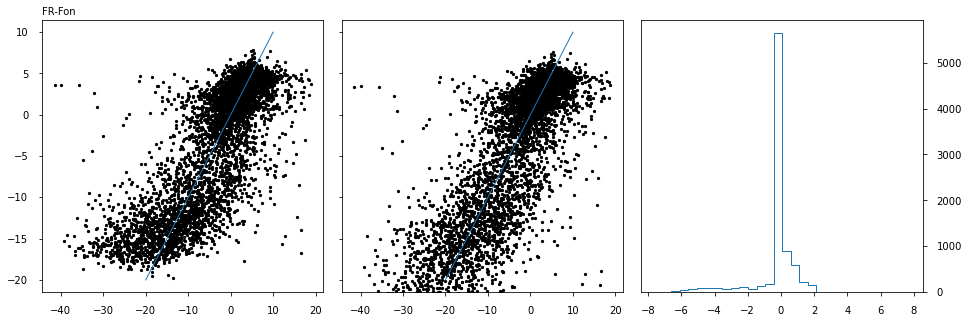

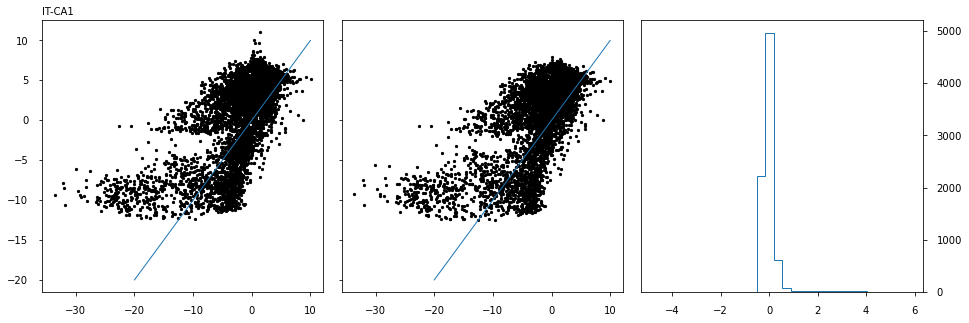

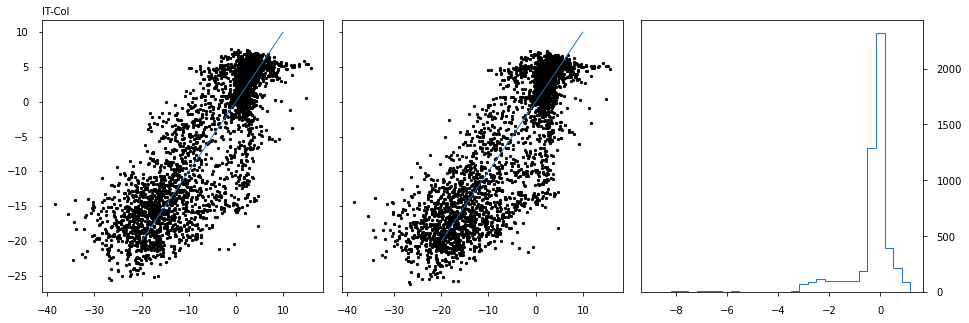

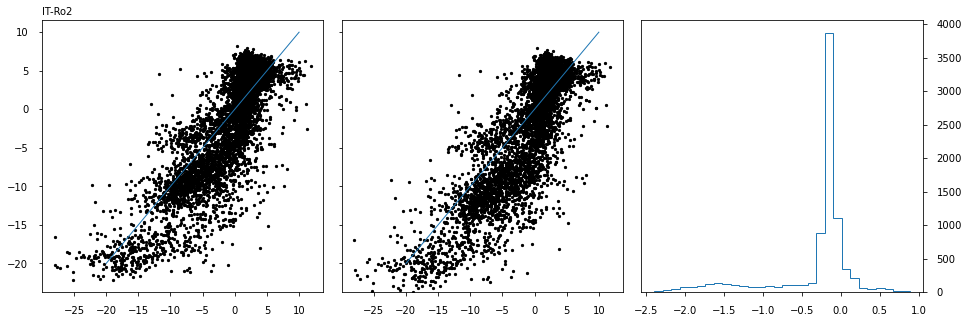

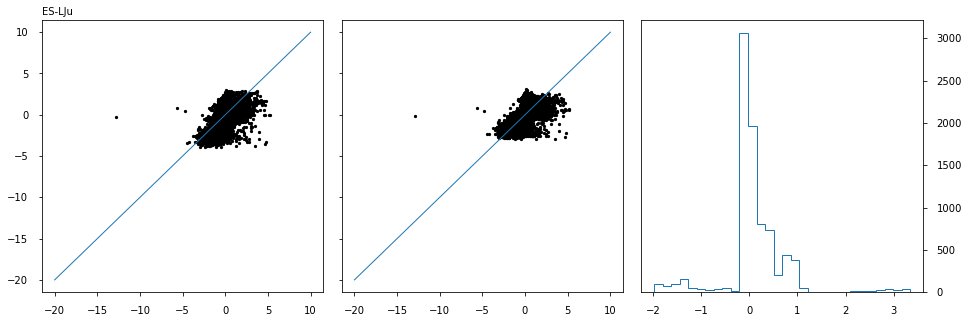

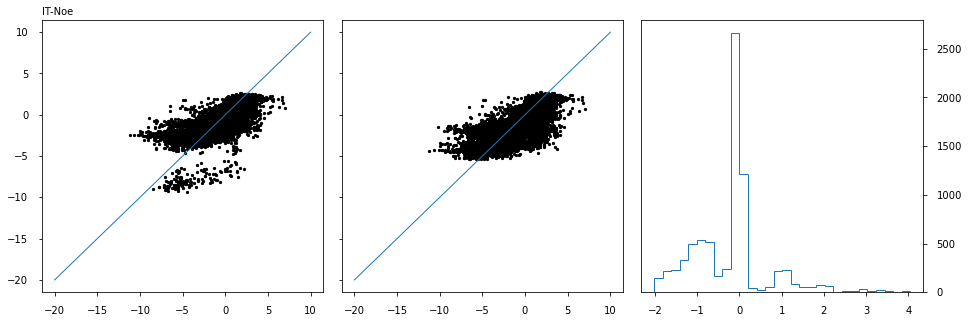

In [143]:
for key in res_dict['modis'].keys():
    print(key)
    inds1 = []
    inds2 = []
    for c, t in enumerate(res_dict['viirs'][key][2]):
        ti = np.where(t==res_dict['modis'][key][2])[0]
        if len(ti)>0:
            inds1.append(c)
            inds2.append(ti[0])
    fig = plt.figure(figsize=figsize(2.0, ratio=0.3))
    ax1 = fig.add_axes((0.,0, 0.31, 1.0))
    ax2 = fig.add_axes((0.33,0, 0.31, 1.0))
    ax3 = fig.add_axes((0.66,0, 0.31, 1.0))
    ax1.scatter(res_dict['modis'][key][1], res_dict['modis'][key][0], color='k', s=5)
    ax2.scatter(res_dict['viirs'][key][1], res_dict['viirs'][key][0], color='k', s=5)
    ax2.set_ylim(ax1.get_ylim())
    ax2.set_yticklabels([])
    ax3.hist(res_dict['viirs'][key][0] - res_dict['modis'][key][0], bins=30, histtype='step')
    ax3.yaxis.tick_right()
    ax1.plot([-20,10], [-20, 10])
    ax2.plot([-20,10], [-20, 10])
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_ylim(ax1.get_ylim())
    ax1.text(0.0, 1.01, key,
          horizontalalignment='left',
          verticalalignment='bottom',
          transform = ax1.transAxes)
    fig.show()